<a href="https://colab.research.google.com/github/mfathul21/scorecard-credit-prediction/blob/main/Scorecard_Credit_Prediction_PB_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Risk Prediction Project**

## **Data Preparation: General**

In [109]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
sns.set_style('darkgrid')

In [110]:
config_data = utils.config_load()
df = pd.read_csv(config_data['raw_dataset_path'], index_col=0)

In [111]:
loan = df.copy()
loan.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
cat_col = loan.select_dtypes(object).columns.to_list()
num_col = loan.select_dtypes(np.number).columns.to_list()

print(f'Total Columns : {len(loan.columns.to_list())}')
print(f'Number of Categorical Columns : {len(cat_col)}')
print(f'Number of Numerical Columns : {len(num_col)}')

Total Columns : 74
Number of Categorical Columns : 22
Number of Numerical Columns : 52


### **Removing Post Approval, Irrelevant, Missing Values, Low Correlation, Multicolinear Features**

In [113]:
config_data['post_approval_columns']

['pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d']

In [114]:
config_data['irrelevant_columns']

['id',
 'member_id',
 'url',
 'desc',
 'emp_title',
 'title',
 'zip_code',
 'policy_code',
 'sub_grade',
 'application_type']

In [115]:
config_data['missing_columns']

['mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [116]:
config_data['low_corr_columns']

['funded_amnt_inv',
 'pub_rec',
 'open_acc',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'tot_coll_amt',
 'acc_now_delinq']

In [117]:
config_data['multicolinearity_columns']

['installment', 'revol_bal', 'funded_amnt']

In [118]:
drop_col = config_data['post_approval_columns'].copy()
drop_col.extend(config_data['irrelevant_columns'])
drop_col.extend(config_data['missing_columns'])
drop_col.extend(config_data['low_corr_columns'])
drop_col.extend(config_data['multicolinearity_columns'])
loan.drop(columns=drop_col, axis=1, inplace=True)

loan.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,revol_util,total_acc,initial_list_status,tot_cur_bal,total_rev_hi_lim
0,5000,36 months,10.65,B,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,AZ,27.65,Jan-85,1.0,83.7,9.0,f,NaN,NaN
1,2500,60 months,15.27,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,GA,1.00,Apr-99,5.0,9.4,4.0,f,NaN,NaN
2,2400,36 months,15.96,C,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,IL,8.72,Nov-01,2.0,98.5,10.0,f,NaN,NaN
3,10000,36 months,13.49,C,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,CA,20.00,Feb-96,1.0,21.0,37.0,f,NaN,NaN
4,3000,60 months,12.69,B,1 year,RENT,80000.0,Source Verified,Dec-11,Current,other,OR,17.94,Jan-96,0.0,53.9,38.0,f,NaN,NaN


### **Data Type Transformation**

In [119]:
print(f"Unique values of term: \n{loan['term'].unique()}")
print(f"\nUnique values of emp_length: \n{loan['emp_length'].unique()}")

Unique values of term: 
[' 36 months' ' 60 months']

Unique values of emp_length: 
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]


In [120]:
loan['term_int'] = loan['term'].str.replace('months', '').str.strip().astype(int)
loan['emp_length_int'] = loan['emp_length'].str.replace(' years', '').str.replace(' year', '')
loan['emp_length_int'] = loan['emp_length_int'].str.replace('+', '').str.replace('<', '')
loan['emp_length_int'] = loan['emp_length_int'].fillna(str(0))
loan['emp_length_int'] = loan['emp_length_int'].str.strip().astype(int)

loan.drop(columns=['term', 'emp_length'], axis=1, inplace=True)
loan[['term_int', 'emp_length_int']].describe()

,term_int,emp_length_int
count,466285.000000,466285.000000
mean,42.605334,5.801081
std,10.719040,3.645496
min,36.000000,0.000000
25%,36.000000,2.000000
50%,36.000000,6.000000
75%,60.000000,10.000000
max,60.000000,10.000000


In [226]:
loan[['issue_d', 'earliest_cr_line']]

In [122]:
utils.date_columns(loan, 'issue_d')
utils.date_columns(loan, 'earliest_cr_line')

loan[['mths_since_issue_d', 'mths_since_earliest_cr_line']].describe()

,mths_since_issue_d,mths_since_earliest_cr_line
count,466285.000000,466256.000000
mean,83.255187,274.385374
std,14.340154,86.460310
min,68.000000,105.000000
25%,73.000000,216.000000
50%,79.000000,258.000000
75%,89.000000,317.000000
max,158.000000,619.000000


### **Imputation Missing Values**

In [123]:
print(f'Shape of data: {loan.shape}\n')
utils.check_missing_values(loan)

Shape of data: (466285, 20)



,count,%rate
total_rev_hi_lim,70276,15%
tot_cur_bal,70276,15%
revol_util,340,0%
inq_last_6mths,29,0%
total_acc,29,0%
mths_since_earliest_cr_line,29,0%
annual_inc,4,0%
loan_status,0,0%
purpose,0,0%
addr_state,0,0%


In [124]:
loan['annual_inc'].fillna(loan['annual_inc'].median(), inplace=True)
loan['tot_cur_bal'].fillna(loan['tot_cur_bal'].median(), inplace=True)
loan['total_rev_hi_lim'].fillna(loan['loan_amnt'], inplace=True)
loan['revol_util'].fillna(round(df['revol_bal'] / loan['total_rev_hi_lim'], 1), inplace=True)
loan['revol_util'].fillna(0, inplace=True)
loan['total_acc'].fillna(0, inplace=True)
loan['inq_last_6mths'].fillna(0, inplace=True)
loan['mths_since_earliest_cr_line'].fillna(0, inplace=True)

print(f'Shape of data: {loan.shape}\n')
utils.check_missing_values(loan)

Shape of data: (466285, 20)



,count,%rate
loan_amnt,0,0%
int_rate,0,0%
mths_since_issue_d,0,0%
emp_length_int,0,0%
term_int,0,0%
total_rev_hi_lim,0,0%
tot_cur_bal,0,0%
initial_list_status,0,0%
total_acc,0,0%
revol_util,0,0%


## **Data Preprocessing - Model**

In [125]:
loan['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

Loan status often has multiple values, requiring a clear definition of what constitutes a defaulting customer to classify them as either a good borrower or a bad borrower.
- **Good borrower**: Current, Fully Paid, In Grace Period, and Does not meet the credit policy. Status:Fully Paid.
- **Bad borrower**: Charged Off, Default, Does not meet the credit policy. Status:Charged Off, Late (31-120 days), and Late (16-30 days).

In [126]:
loan['loan_status'].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [127]:
loan['good_loan'] = np.where(loan['loan_status'].isin(['Charged Off', 'Default',
                                                      'Does not meet the credit policy. Status:Charged Off',
                                                      'Late (31-120 days)', 'Late (16-30 days)']), 0, 1)

loan.drop(columns='loan_status', axis=1, inplace=True)
loan['good_loan'].value_counts()

good_loan
1    414099
0     52186
Name: count, dtype: int64

### **Binning, Weight of Evidence and Information Value**

Binning is the process of transforming continuous variables into discrete bins or categories. This is often used in credit scoring to simplify the relationship between predictors (independent variables) and the target variable (dependent variable). By grouping continuous values into bins, we can better analyze patterns and trends within the data.

Two statistical metrics used primarily in credit scoring to evaluate the predictive power of individual variables are Weight of Evidence (WoE) and Information Value (IV). These metrics help in understanding the relationship between a predictor and the binary target.

**Binning**

Binning create buckets of independent variables based on ranking methods. Binning helps us converting continuous variables into categorical ones. This process allows us to understand feature performance better. The insights from this part of the analysis can be useful in devising portfolio risk strategies. One simple binning example using "age" is given below for illustration.

| Original Age | Binned Age |
|--------------|------------|
| 10           | [0-10]     |
| 15           | [11-20]    |
| 25           | [21-30]    |


**Weight of Evidence (WoE)**

The WoE measures the strength of a predictor in relation to the target variable. For a binary classification problem, WoE for each category (bin) of a predictor variable is calculated as follows:

$\text{WoE}_i = \ln\left(\frac{\text{Good}_i / \text{Total Good}}{\text{Bad}_i / \text{Total Bad}}\right)$

Where:
- $\text{Good}_i$ is the number of good outcomes in bin $\text{i}$.
- $\text{Total Good}$ is the total number of good outcomes.
- $\text{Bad}_i$ is the number of bad outcomes in bin $\text{i}$.
- $\text{Total Bad}$ is the total number of bad outcomes.

Interpretation of WoE:
- Positive WoE: Indicates that a particular category is associated with a higher proportion of good outcomes (e.g., lower default risk).
- Negative WoE: Indicates that a particular category is associated with a higher proportion of bad outcomes (e.g., higher default risk).
- WoE close to zero: Suggests that the category has no strong discriminatory power between good and bad outcomes.

**Information Value (IV)**

The IV measures the overall predictive power of a variable. It's the sum of the WoE values weighted by the difference in the distribution of good and bad outcomes:

$\text{IV} = \sum_i (\text{Good}_i - \text{Bad}_i) \times \text{WoE}_i$

Where:
- $\text{Good}_i$ and $\text{Bad}_i$ are the proportions of good and bad outcomes in bin $\text{i}$, respectively.

Interpretation of IV:
- IV < 0.02: Predictive power is not useful.
- 0.02 ≤ IV < 0.1: Predictive power is weak.
- 0.1 ≤ IV < 0.3: Predictive power is medium.
- 0.3 ≤ IV < 0.5: Predictive power is strong.
- IV ≥ 0.5: Predictive power is suspiciously strong (possible overfitting).

In [128]:
iv, woe = utils.iv_woe(loan[config_data['original_columns']], 
                       target='good_loan', bins=20)

iv.sort_values(by='IV', ascending=False)

,Variable,IV
0,int_rate,0.332552
0,grade,0.293442
0,mths_since_issue_d,0.097964
0,tot_cur_bal,0.055424
0,annual_inc,0.052782
0,total_rev_hi_lim,0.041516
0,term_int,0.039371
0,purpose,0.036799
0,inq_last_6mths,0.036261
0,revol_util,0.027513


The rule of thumb says that all variables with IV < 0.02 are not useful for prediction and IV > 0.5 have a suspicious predictive power. Therefore, the following variables will not be included mths_since_earliest_cr_line, addr_state, total_acc, emp_length_int, and loan_amnt.

In [129]:
loan.drop(columns=['mths_since_earliest_cr_line', 'addr_state',
                   'total_acc', 'emp_length_int', 'loan_amnt'], axis=1, inplace=True)

### **Dummy Variables**

In [130]:
loan.select_dtypes([object]).sample(5) 

,grade,home_ownership,verification_status,purpose,initial_list_status
305516,C,RENT,Verified,debt_consolidation,w
66105,C,MORTGAGE,Source Verified,debt_consolidation,w
249719,C,MORTGAGE,Source Verified,debt_consolidation,w
347896,A,RENT,Not Verified,debt_consolidation,w
264594,C,MORTGAGE,Not Verified,debt_consolidation,w


In [131]:
dummies_col = [
'grade', 'home_ownership', 'verification_status',
'purpose', 'initial_list_status']
list_dummies = []

for col in dummies_col:
  list_dummies.append(pd.get_dummies(loan[col], prefix=col, prefix_sep=':'))

loan_dummies = pd.concat(list_dummies, axis=1)
loan_dummies.sample(5)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,initial_list_status:f,initial_list_status:w
168789,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
184697,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
389181,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
165362,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
169370,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True


In [132]:
loan_dummies.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'home_ownership:ANY', 'home_ownership:MORTGAGE',
       'home_ownership:NONE', 'home_ownership:OTHER',
       'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Not Verified',
       'verification_status:Source Verified',
       'verification_status:Verified', 'purpose:car',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:educational', 'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:f', 'initial_list_status:w'], dtype=object)

In [133]:
loan = pd.concat([loan, loan_dummies], axis=1)
loan.sample(5)

,int_rate,grade,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,initial_list_status,tot_cur_bal,total_rev_hi_lim,term_int,mths_since_issue_d,good_loan,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,initial_list_status:f,initial_list_status:w
46998,14.98,C,OWN,40000.0,Not Verified,debt_consolidation,20.37,0.0,46.8,f,24707.0,9900.0,36,80,1,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
28072,7.88,A,MORTGAGE,62000.0,Not Verified,debt_consolidation,8.94,3.0,26.0,f,81539.0,5000.0,36,121,1,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
293935,23.43,F,RENT,95000.0,Verified,debt_consolidation,7.35,1.0,58.7,w,14782.0,25200.0,60,70,1,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
138355,11.14,B,MORTGAGE,55200.0,Not Verified,car,11.70,0.0,53.7,f,117866.0,3900.0,36,87,1,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
360861,18.99,E,RENT,56500.0,Not Verified,moving,21.09,1.0,57.5,w,63403.0,13900.0,36,73,1,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [134]:
X = loan.drop(columns = 'good_loan', axis=1)
y = loan['good_loan']

### **Analyzing Categorical Variables by Plotting WoE**

#### **1. WoE of Grade Features**

In [135]:
df_temp = utils.woe_discrete(X, 'grade', y)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,G,3322,0.716436,0.007124,2380.0,942.0,0.005747,0.018051,-1.144440,0.293442
1,F,13229,0.753043,0.028371,9962.0,3267.0,0.024057,0.062603,-0.956385,0.293442
2,E,35757,0.800347,0.076685,28618.0,7139.0,0.069109,0.136799,-0.682828,0.293442
3,D,76888,0.842212,0.164895,64756.0,12132.0,0.156378,0.232476,-0.396511,0.293442
4,C,125293,0.882332,0.268705,110550.0,14743.0,0.266965,0.282509,-0.056591,0.293442
5,B,136929,0.919608,0.293659,125921.0,11008.0,0.304084,0.210938,0.365742,0.293442
6,A,74867,0.960530,0.160561,71912.0,2955.0,0.173659,0.056624,1.120654,0.293442


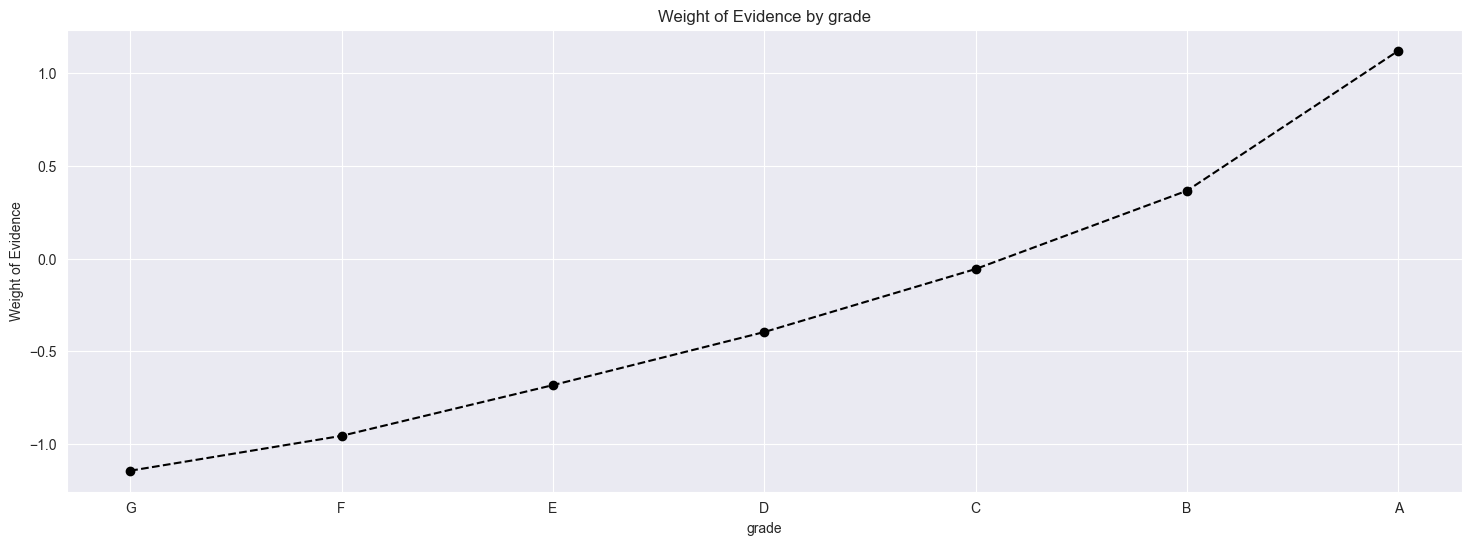

In [136]:
utils.plot_by_woe(df_temp)

We can see from the above graph that the grades have significantly different woe as we grade changes. We will therefore keep each grade as a feature.

#### **2. WoE of Home Ownership Features**

In [137]:
df_temp = utils.woe_discrete(X, 'home_ownership', y)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,OTHER,182,0.791209,0.000390,144.0,38.0,0.000348,0.000728,-0.739064,inf
1,NONE,50,0.840000,0.000107,42.0,8.0,0.000101,0.000153,-0.413063,inf
2,RENT,188473,0.871334,0.404201,164223.0,24250.0,0.396579,0.464684,-0.158482,inf
3,OWN,41704,0.888668,0.089439,37061.0,4643.0,0.089498,0.088970,0.005914,inf
4,MORTGAGE,235875,0.901444,0.505860,212628.0,23247.0,0.513471,0.445464,0.142077,inf
5,ANY,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,inf


OTHER, NONE and ANY have very few observations and should be combined with the category with high risk of default that is RENT.

In [138]:
rent_other_any_none = X[X['home_ownership'].isin(['RENT', 'OTHER','ANY', 'NONE'])].index
X.loc[rent_other_any_none, 'home_ownership'] = 'RENT_OTHER_ANY_NONE'

df_temp = utils.woe_discrete(X, 'home_ownership', y)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,RENT_OTHER_ANY_NONE,188706,0.871249,0.404701,164410.0,24296.0,0.397031,0.465565,-0.159239,0.020579
1,OWN,41704,0.888668,0.089439,37061.0,4643.0,0.089498,0.088970,0.005914,0.020579
2,MORTGAGE,235875,0.901444,0.505860,212628.0,23247.0,0.513471,0.445464,0.142077,0.020579


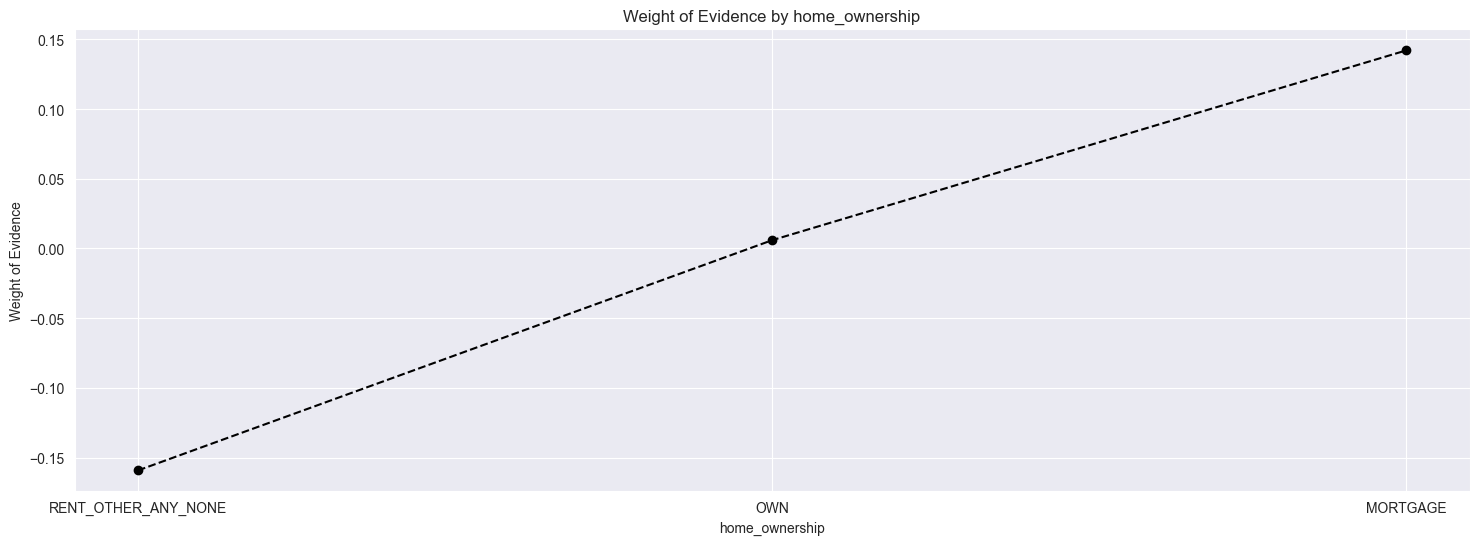

In [139]:
utils.plot_by_woe(df_temp)

In [140]:
X['home_ownership:RENT_OTHER_ANY_NONE'] = np.sum(X[['home_ownership:RENT',
                                                    'home_ownership:OTHER',
                                                    'home_ownership:ANY',
                                                    'home_ownership:NONE']], axis = 1)

#### **3. WoE of Verification Status Features**

In [141]:
df_temp = utils.woe_discrete(X, 'verification_status', y)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,Verified,168055,0.869739,0.360413,146164.0,21891.0,0.352969,0.419480,-0.172637,0.021113
1,Source Verified,149993,0.892728,0.321677,133903.0,16090.0,0.323360,0.308320,0.047627,0.021113
2,Not Verified,148237,0.904174,0.317911,134032.0,14205.0,0.323671,0.272199,0.173194,0.021113


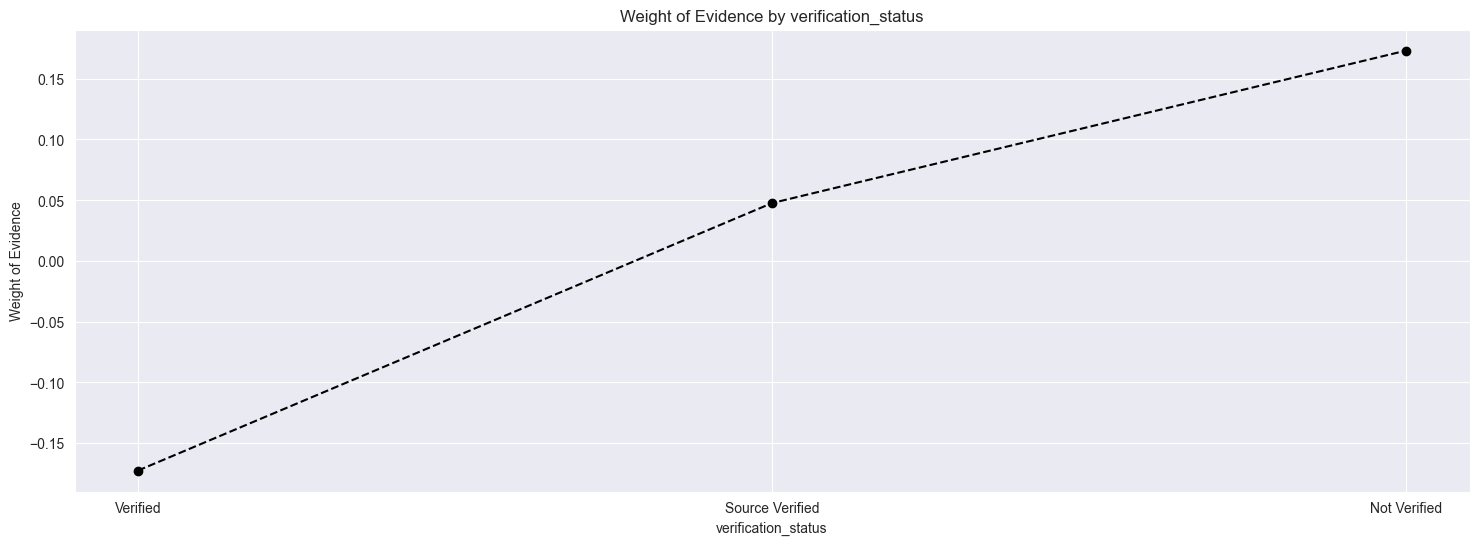

In [142]:
utils.plot_by_woe(df_temp)

This variable has different WoE values and can be used as seperate variables.

#### **4. WoE of Purpose Features**

In [143]:
df_temp = utils.woe_discrete(X, 'purpose', y)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,small_business,7013,0.779552,0.015040,5467.0,1546.0,0.013202,0.029625,-0.808232,0.036799
1,educational,422,0.791469,0.000905,334.0,88.0,0.000807,0.001686,-0.737487,0.036799
2,moving,2994,0.844689,0.006421,2529.0,465.0,0.006107,0.008910,-0.377749,0.036799
3,renewable_energy,351,0.846154,0.000753,297.0,54.0,0.000717,0.001035,-0.366543,0.036799
4,house,2269,0.858087,0.004866,1947.0,322.0,0.004702,0.006170,-0.271797,0.036799
5,other,23690,0.859054,0.050806,20351.0,3339.0,0.049145,0.063983,-0.263832,0.036799
6,medical,4602,0.864407,0.009870,3978.0,624.0,0.009606,0.011957,-0.218907,0.036799
7,vacation,2487,0.877362,0.005334,2182.0,305.0,0.005269,0.005844,-0.103605,0.036799
8,wedding,2343,0.878361,0.005025,2058.0,285.0,0.004970,0.005461,-0.094290,0.036799
9,debt_consolidation,274195,0.883893,0.588042,242359.0,31836.0,0.585268,0.610049,-0.041468,0.036799


Notice that some features will be combined into one category based on their similar WoE values and relatively small number of observations. Additionally, other categories are combined considering similar WoE values and a relatively small number of observations as follows:
- small_business, educational, moving, wedding, and house
- other, renewable_energy, vacation, and medical
- major_purchase, car, and home_improvement

In [144]:
group1 = X[X['purpose'].isin(['small_business', 'educational', 'moving', 'wedding', 'house'])].index
group2 = X[X['purpose'].isin(['other', 'renewable_energy', 'vacation', 'medical'])].index
group3 = X[X['purpose'].isin(['major_purchase', 'car', 'home_improvement'])].index
X.loc[group1, 'purpose'] = 'small_business_educational_moving_wedding_house'
X.loc[group2, 'purpose'] = 'other_renewable_energy_vacation_medical'
X.loc[group3, 'purpose'] = 'major_purchase_car_home_improvement'

df_temp = utils.woe_discrete(X, 'purpose', y)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,small_business_educational_moving_wedding_house,15041,0.820092,0.032257,12335.0,2706.0,0.029788,0.051853,-0.554322,0.033325
1,other_renewable_energy_vacation_medical,31130,0.861163,0.066762,26808.0,4322.0,0.064738,0.082819,-0.246309,0.033325
2,debt_consolidation,274195,0.883893,0.588042,242359.0,31836.0,0.585268,0.610049,-0.041468,0.033325
3,major_purchase_car_home_improvement,41762,0.901298,0.089563,37640.0,4122.0,0.090896,0.078987,0.140438,0.033325
4,credit_card,104157,0.911672,0.223376,94957.0,9200.0,0.229310,0.176292,0.262930,0.033325


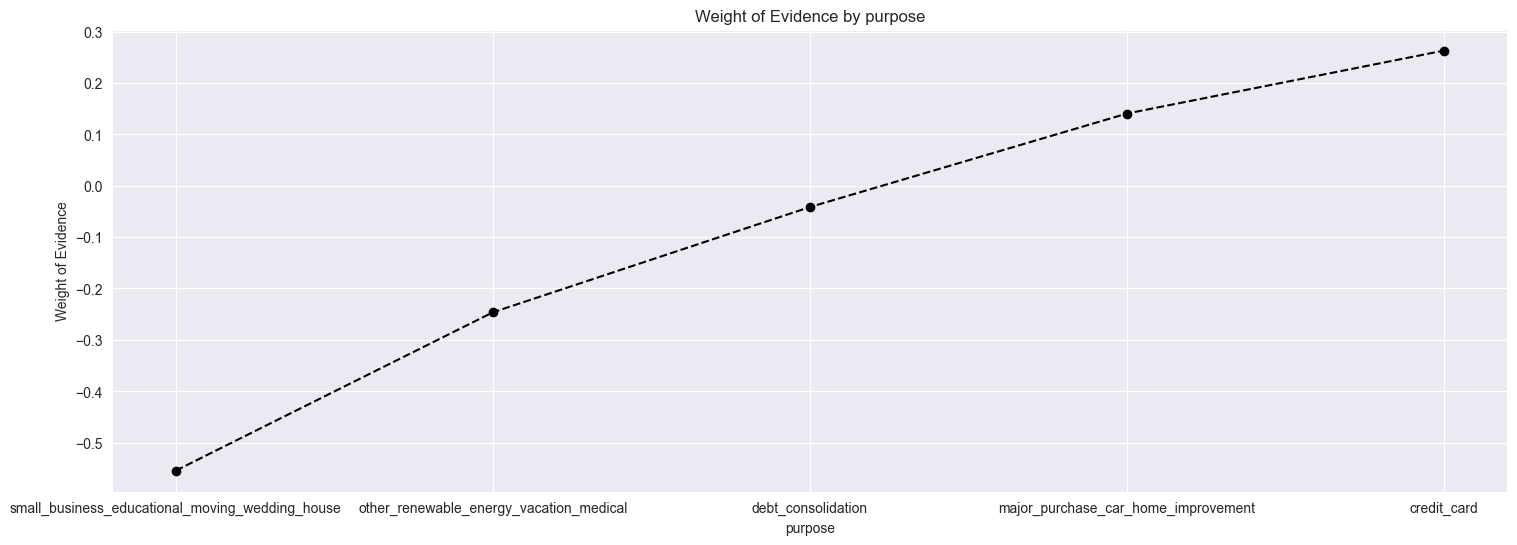

In [145]:
utils.plot_by_woe(df_temp)

In [146]:
X['purpose:small_business_educational_moving_wedding_house'] = np.sum(X[['purpose:small_business',
                                                                          'purpose:educational',
                                                                          'purpose:moving',
                                                                          'purpose:wedding',
                                                                          'purpose:house']], axis = 1)

X['purpose:other_renewable_energy_vacation_medical'] = np.sum(X[['purpose:other',
                                                                 'purpose:renewable_energy',
                                                                 'purpose:vacation',
                                                                 'purpose:medical']], axis = 1)

X['purpose:major_purchase_car_home_improvement'] = np.sum(X[['purpose:major_purchase',  
                                        'purpose:car',
                                        'purpose:home_improvement']], axis = 1)

#### **5. WoE of List Status Features**

In [147]:
df_temp = utils.woe_discrete(X, 'initial_list_status', y)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,f,303005,0.877487,0.649828,265883.0,37122.0,0.642076,0.71134,-0.102444,0.021993
1,w,163280,0.907741,0.350172,148216.0,15064.0,0.357924,0.28866,0.215072,0.021993


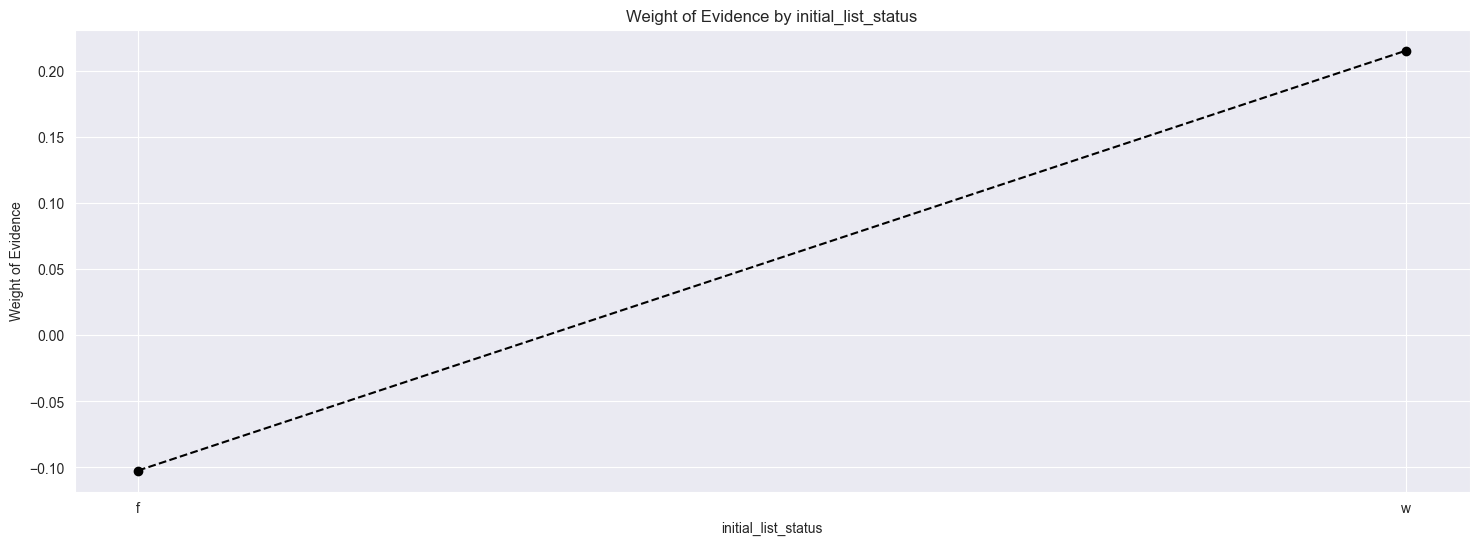

In [148]:
utils.plot_by_woe(df_temp)

### **Analyzing Numerical Features by Plotting WoE**

In [149]:
loan.select_dtypes([int, float]).head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_util,tot_cur_bal,total_rev_hi_lim,term_int,mths_since_issue_d,good_loan
0,10.65,24000.0,27.65,1.0,83.7,81539.0,5000.0,36,104,1
1,15.27,30000.0,1.00,5.0,9.4,81539.0,2500.0,60,104,0
2,15.96,12252.0,8.72,2.0,98.5,81539.0,2400.0,36,104,1
3,13.49,49200.0,20.00,1.0,21.0,81539.0,10000.0,36,104,1
4,12.69,80000.0,17.94,0.0,53.9,81539.0,3000.0,60,104,1


#### **1. WoE of Interest Rate Features**

In [150]:
X['int_rate'].unique()

array([10.65, 15.27, 15.96, 13.49, 12.69,  7.9 , 18.64, 21.28, 14.65,
        9.91, 16.29,  6.03, 11.71, 12.42, 14.27, 16.77,  7.51,  8.9 ,
       18.25,  6.62, 19.91, 17.27, 17.58, 21.67, 19.42, 22.06, 20.89,
       20.3 , 23.91, 19.03, 23.52, 23.13, 22.74, 22.35, 24.11,  6.  ,
       22.11,  7.49, 11.99,  5.99, 10.99,  9.99, 18.79, 11.49,  8.49,
       15.99, 16.49,  6.99, 12.99, 15.23, 14.79,  5.42, 10.59, 17.49,
       15.62, 21.36, 19.29, 13.99, 18.39, 16.89, 17.99, 20.62, 20.99,
       22.85, 19.69, 20.25, 23.22, 21.74, 22.48, 23.59, 12.62, 18.07,
       11.63,  7.91,  7.42, 11.14, 20.2 , 12.12, 19.39, 16.11, 17.54,
       22.64, 13.84, 16.59, 17.19, 12.87, 20.69,  9.67, 21.82, 19.79,
       18.49, 22.94, 24.59, 24.4 , 21.48, 14.82, 14.17,  7.29, 17.88,
       20.11, 16.02, 17.51, 13.43, 14.91, 13.06, 15.28, 15.65, 17.14,
       11.11, 10.37, 16.4 ,  7.66, 10.  , 18.62, 10.74,  5.79,  6.92,
        9.63, 14.54, 12.68, 19.36, 13.8 , 18.99, 21.59, 20.85, 21.22,
       19.74, 20.48,

In [151]:
X['int_rate_factor'] = pd.cut(X['int_rate'],50)
X['int_rate_factor'].unique()

[(10.374, 10.786], (14.914, 15.327], (15.74, 16.153], (13.263, 13.676], (12.438, 12.85], ..., (24.409, 24.822], (9.135, 9.548], (25.647, 26.06], (24.822, 25.234], (25.234, 25.647]]
Length: 50
Categories (50, interval[float64, right]): [(5.399, 5.833] < (5.833, 6.246] < (6.246, 6.658] < (6.658, 7.071] ... (24.409, 24.822] < (24.822, 25.234] < (25.234, 25.647] < (25.647, 26.06]]

In [152]:
df_temp = utils.woe_ordered_continuous(X, 'int_rate_factor', y)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(5.399, 5.833]",983,0.963377,0.002108,947.0,36.0,0.002287,0.000690,1.198489,0.347897
1,"(5.833, 6.246]",10545,0.979611,0.022615,10330.0,215.0,0.024946,0.004120,1.800879,0.347897
2,"(6.246, 6.658]",9800,0.970918,0.021017,9515.0,285.0,0.022978,0.005461,1.436845,0.347897
3,"(6.658, 7.071]",2293,0.967728,0.004918,2219.0,74.0,0.005359,0.001418,1.329456,0.347897
4,"(7.071, 7.484]",3947,0.977198,0.008465,3857.0,90.0,0.009314,0.001725,1.686544,0.347897
5,"(7.484, 7.897]",15826,0.962277,0.033941,15229.0,597.0,0.036776,0.011440,1.167749,0.347897
6,"(7.897, 8.31]",12116,0.949323,0.025984,11502.0,614.0,0.027776,0.011766,0.858990,0.347897
7,"(8.31, 8.722]",8274,0.963863,0.017745,7975.0,299.0,0.019259,0.005730,1.212333,0.347897
8,"(8.722, 9.135]",11923,0.937012,0.025570,11172.0,751.0,0.026979,0.014391,0.628469,0.347897
9,"(9.135, 9.548]",8271,0.964817,0.017738,7980.0,291.0,0.019271,0.005576,1.240080,0.347897


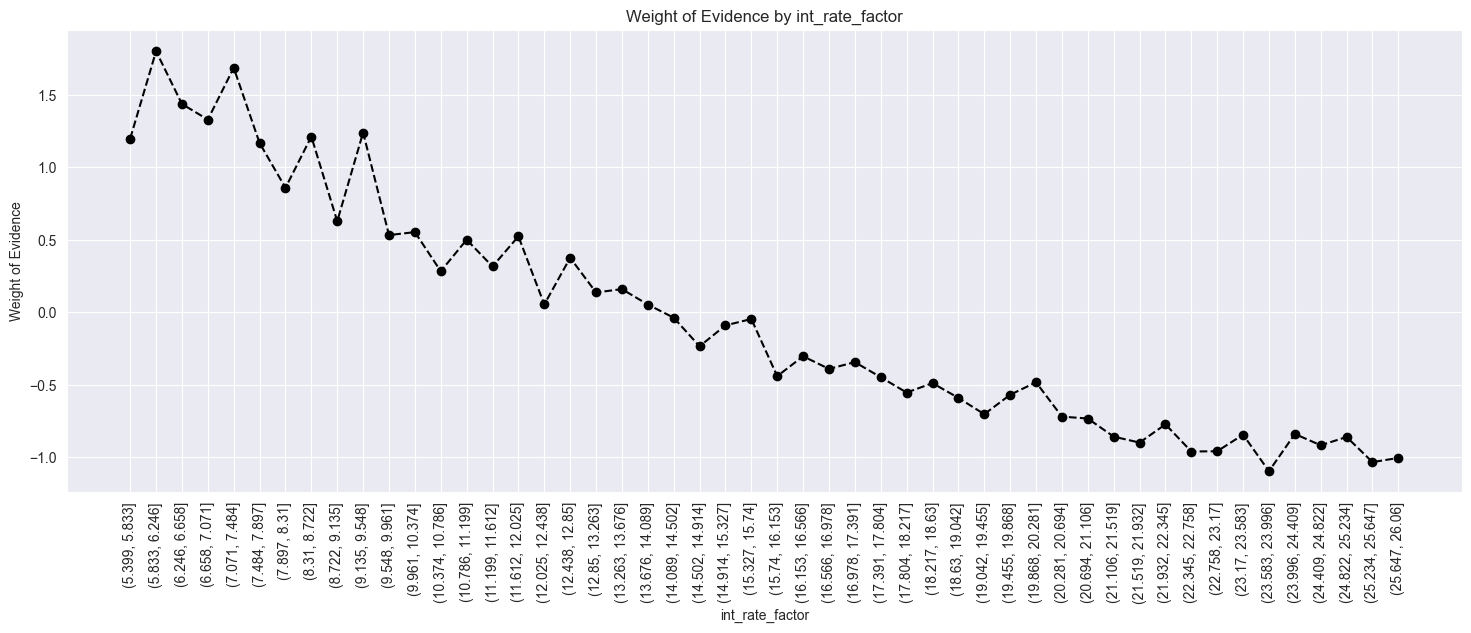

In [153]:
utils.plot_by_woe(df_temp, 90)

Based on the WoE graph, considering the proportion of each binned category and the closely related WoE values of these categories, some values can be grouped into a single category. Therefore, the feature `int_rate` will have the following categories:
- int_rate:<9.548
- int_rate:9.548-12.025
- int_rate:12.026-15.74
- int_rate:15.75-20.281
- int_rate:>20.281

In [154]:
bins = [-float('inf'), 9.548, 12.026, 15.76, 20.282, float('inf')]
labels = ['int_rate:<9.548', 'int_rate:9.548-12.025', 'int_rate:12.026-15.74', 'int_rate:15.75-20.281', 'int_rate:>20.281']
X['int_rate_factor'] = pd.cut(X['int_rate'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X, 'int_rate_factor', y)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,int_rate:<9.548,83978,0.961276,0.180100,80726.0,3252.0,0.194944,0.062316,1.140500,0.319728
1,int_rate:9.548-12.025,78161,0.927803,0.167625,72518.0,5643.0,0.175122,0.108132,0.482128,0.319728
2,int_rate:12.026-15.74,162814,0.892368,0.349173,145290.0,17524.0,0.350858,0.335799,0.043870,0.319728
3,int_rate:15.75-20.281,104504,0.834313,0.224120,87189.0,17315.0,0.210551,0.331794,-0.454786,0.319728
4,int_rate:>20.281,36828,0.770501,0.078982,28376.0,8452.0,0.068525,0.161959,-0.860150,0.319728


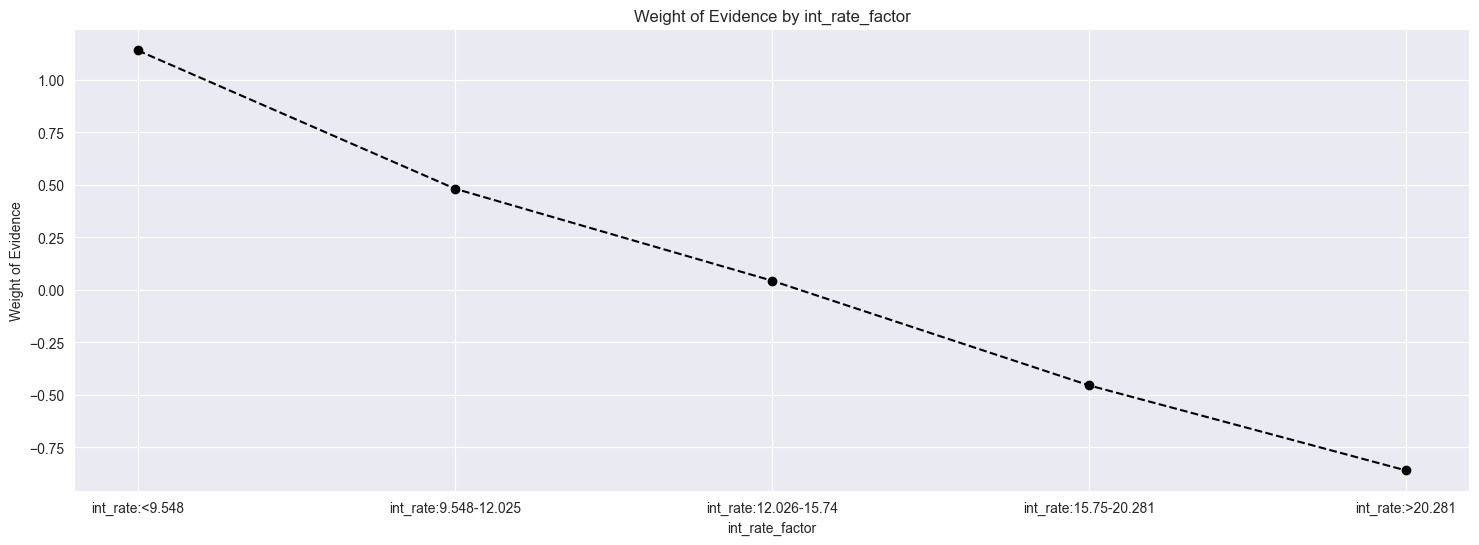

In [155]:
utils.plot_by_woe(df_temp)

In [156]:
X['int_rate:<9.548'] = np.where((X['int_rate'] < 9.548), 1, 0)
X['int_rate:9.548-12.025'] = np.where((X['int_rate'].between(9.548, 12.025)), 1, 0)
X['int_rate:12.026-15.74'] = np.where((X['int_rate'].between(12.026, 15.74)), 1, 0)
X['int_rate:15.75-20.281'] = np.where((X['int_rate'].between(15.75, 20.281)), 1, 0)
X['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)

#### **2. WoE of Annual Income Features**

In [157]:
X['annual_inc'].unique()

array([ 24000.,  30000.,  12252., ..., 284481., 113926.,  72787.])

In [158]:
X['annual_inc_factor'] = pd.cut(X['annual_inc'],50)
X['annual_inc_factor'].unique()

[(-5602.104, 151858.08], (151858.08, 301820.16], (451782.24, 601744.32], (301820.16, 451782.24], (601744.32, 751706.4], ..., (7050113.76, 7200075.84], (4950644.64, 5100606.72], (4800682.56, 4950644.64], (7350037.92, 7500000.0], (4500758.4, 4650720.48]]
Length: 22
Categories (50, interval[float64, right]): [(-5602.104, 151858.08] < (151858.08, 301820.16] < (301820.16, 451782.24] < (451782.24, 601744.32] ... (6900151.68, 7050113.76] < (7050113.76, 7200075.84] < (7200075.84, 7350037.92] < (7350037.92, 7500000.0]]

In [159]:
df_temp = utils.woe_ordered_continuous(X, 'annual_inc_factor', y)
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-5602.104, 151858.08]",445843,0.886373,0.956160,395183.0,50660.0,0.954320,0.970758,-0.017079,inf
1,"(151858.08, 301820.16]",18425,0.924613,0.039514,17036.0,1389.0,0.041140,0.026616,0.435454,inf
2,"(301820.16, 451782.24]",1368,0.930556,0.002934,1273.0,95.0,0.003074,0.001820,0.523964,inf
3,"(451782.24, 601744.32]",372,0.940860,0.000798,350.0,22.0,0.000845,0.000422,0.695600,inf
4,"(601744.32, 751706.4]",115,0.904348,0.000247,104.0,11.0,0.000251,0.000211,0.175205,inf
5,"(751706.4, 901668.48]",73,0.904110,0.000157,66.0,7.0,0.000159,0.000134,0.172454,inf
6,"(901668.48, 1051630.56]",33,0.969697,0.000071,32.0,1.0,0.000077,0.000019,1.394445,inf
7,"(1051630.56, 1201592.64]",21,1.000000,0.000045,21.0,0.0,0.000051,0.000000,inf,inf
8,"(1201592.64, 1351554.72]",10,0.900000,0.000021,9.0,1.0,0.000022,0.000019,0.125934,inf
9,"(1351554.72, 1501516.8]",6,1.000000,0.000013,6.0,0.0,0.000014,0.000000,inf,inf


The feature `annual income` has outliers that result in ineffective fine classing binning, causing an imbalance in observations for each category and even some categories having 0 observations. Therefore, it is recommended to increase the number of smaller bins by dividing them into 100 bins to achieve a more reasonable number of observations for each bin, and then pruning them accordingly.

In [160]:
pd.options.display.max_rows=200
X['annual_inc_factor'] = pd.cut(X['annual_inc'],100)

df_temp = utils.woe_ordered_continuous(X, 'annual_inc_factor', y)
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-5602.104, 76877.04]",306443,0.874743,0.657201,268059.0,38384.0,0.647331,0.735523,-0.127724,inf
1,"(76877.04, 151858.08]",139400,0.911937,0.298959,127124.0,12276.0,0.306989,0.235236,0.266226,inf
2,"(151858.08, 226839.12]",14866,0.924660,0.031882,13746.0,1120.0,0.033195,0.021462,0.436128,inf
3,"(226839.12, 301820.16]",3559,0.924417,0.007633,3290.0,269.0,0.007945,0.005155,0.432641,inf
4,"(301820.16, 376801.2]",867,0.926182,0.001859,803.0,64.0,0.001939,0.001226,0.458181,inf
5,"(376801.2, 451782.24]",501,0.938124,0.001074,470.0,31.0,0.001135,0.000594,0.647455,inf
6,"(451782.24, 526763.28]",232,0.952586,0.000498,221.0,11.0,0.000534,0.000211,0.928977,inf
7,"(526763.28, 601744.32]",140,0.921429,0.000300,129.0,11.0,0.000312,0.000211,0.390626,inf
8,"(601744.32, 676725.36]",55,0.890909,0.000118,49.0,6.0,0.000118,0.000115,0.028770,inf
9,"(676725.36, 751706.4]",60,0.916667,0.000129,55.0,5.0,0.000133,0.000096,0.326604,inf


Note that for annual income above 230,000, the number of observations is small, so WoE and IV calculations will be performed only for annual income below 230,000.

In [161]:
X_temp = X.loc[X['annual_inc'] <= 230000, : ]
X_temp['annual_inc_factor'] = pd.cut(X_temp['annual_inc'],50)

df_temp = utils.woe_ordered_continuous(X_temp, 'annual_inc_factor', y[X_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(1667.896, 6458.08]",42,0.809524,0.000091,34.0,8.0,0.000083,0.000154,-0.619841,0.052878
1,"(6458.08, 11020.16]",546,0.835165,0.001184,456.0,90.0,0.001114,0.001737,-0.444077,0.052878
2,"(11020.16, 15582.24]",1932,0.822464,0.004191,1589.0,343.0,0.003883,0.006622,-0.533630,0.052878
3,"(15582.24, 20144.32]",4632,0.850389,0.010048,3939.0,693.0,0.009627,0.013379,-0.329108,0.052878
4,"(20144.32, 24706.4]",6676,0.845416,0.014483,5644.0,1032.0,0.013794,0.019923,-0.367666,0.052878
5,"(24706.4, 29268.48]",13196,0.850637,0.028627,11225.0,1971.0,0.027434,0.038051,-0.327157,0.052878
6,"(29268.48, 33830.56]",19306,0.857764,0.041881,16560.0,2746.0,0.040472,0.053013,-0.269915,0.052878
7,"(33830.56, 38392.64]",25473,0.859066,0.055260,21883.0,3590.0,0.053481,0.069306,-0.259202,0.052878
8,"(38392.64, 42954.72]",29737,0.863672,0.064510,25683.0,4054.0,0.062769,0.078264,-0.220635,0.052878
9,"(42954.72, 47516.8]",28928,0.872131,0.062755,25229.0,3699.0,0.061659,0.071411,-0.146828,0.052878


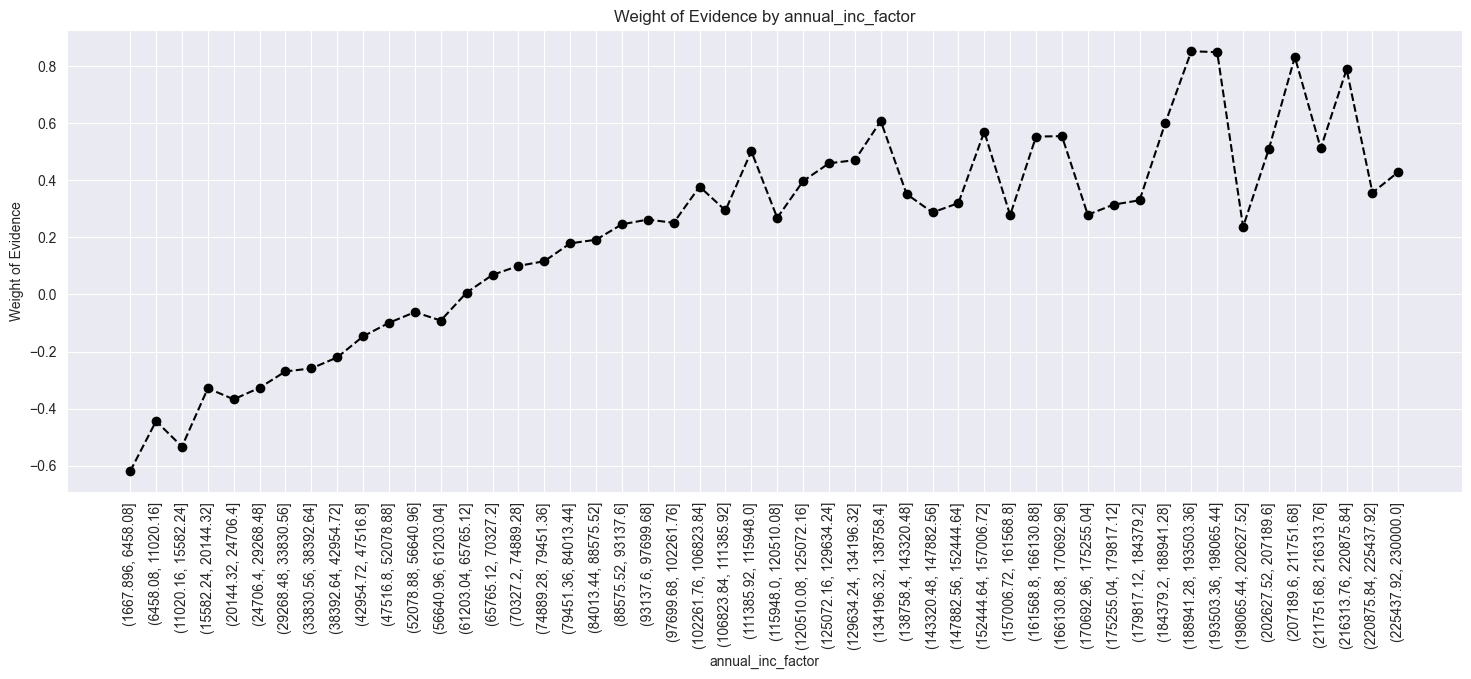

In [162]:
utils.plot_by_woe(df_temp, 90)

- annual_inc:<20k
- annual_inc:20k-30k
- annual_inc:30k-40k
- annual_inc:40k-50k
- annual_inc:50k-60k
- annual_inc:60k-70k
- annual_inc:70k-80k
- annual_inc:80k-100k
- annual_inc:>100k

In [163]:
bins = [-float('inf'), 20001, 30001, 40001, 50001, 60001, 70001, 80001, 100001, float('inf')]
labels = ['annual_inc:<20k', 'annual_inc:20k-30k', 'annual_inc:30k-40k', 
          'annual_inc:40k-50k', 'annual_inc:50k-60k', 'annual_inc:60k-70k', 
          'annual_inc:70k-80k', 'annual_inc:80k-100k', 'annual_inc:>100k']
X_temp['annual_inc_factor'] = pd.cut(X['annual_inc'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'annual_inc_factor', y)
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,annual_inc:<20k,7088,0.841563,0.015376,5965.0,1123.0,0.014578,0.021680,-0.396854,0.050715
1,annual_inc:20k-30k,28020,0.851606,0.060785,23862.0,4158.0,0.058318,0.080272,-0.319507,0.050715
2,annual_inc:30k-40k,53964,0.859555,0.117066,46385.0,7579.0,0.113364,0.146316,-0.255165,0.050715
3,annual_inc:40k-50k,68645,0.871950,0.148915,59855.0,8790.0,0.146284,0.169694,-0.148450,0.050715
4,annual_inc:50k-60k,66512,0.880007,0.144287,58531.0,7981.0,0.143048,0.154076,-0.074267,0.050715
5,annual_inc:60k-70k,54169,0.891082,0.117511,48269.0,5900.0,0.117968,0.113902,0.035077,0.050715
6,annual_inc:70k-80k,46880,0.898592,0.101699,42126.0,4754.0,0.102955,0.091778,0.114919,0.050715
7,annual_inc:80k-100k,63352,0.908937,0.137432,57583.0,5769.0,0.140731,0.111373,0.233969,0.050715
8,annual_inc:>100k,72339,0.920582,0.156928,66594.0,5745.0,0.162754,0.110909,0.383525,0.050715


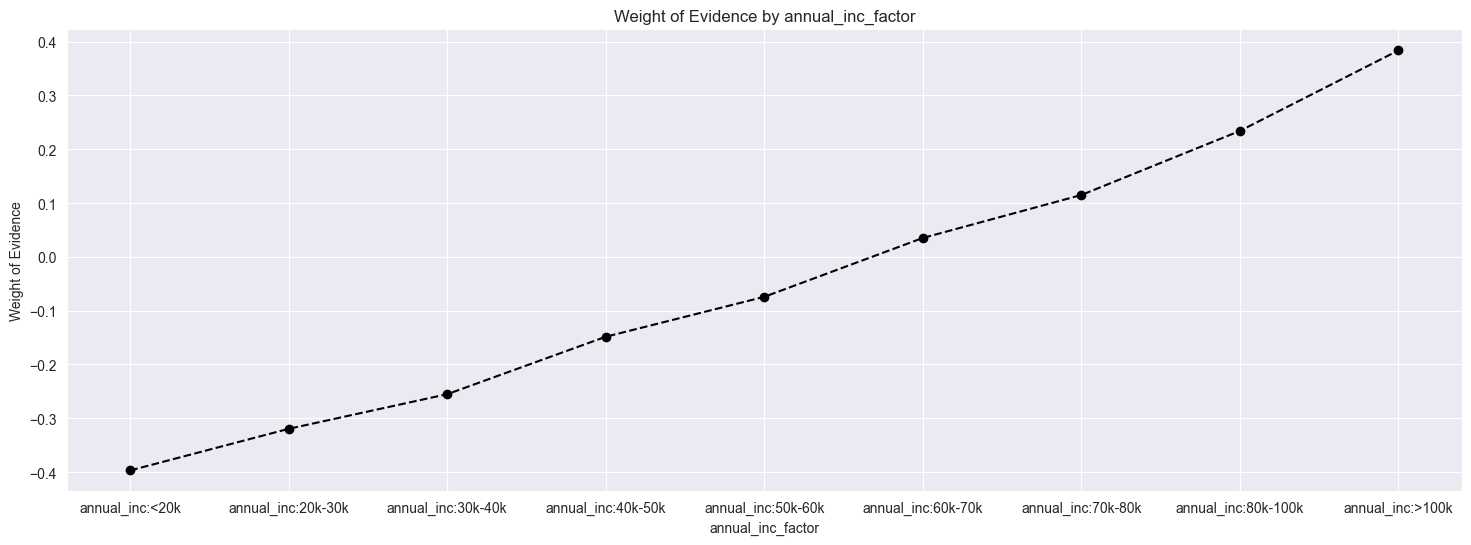

In [164]:
utils.plot_by_woe(df_temp)

In [165]:
X['annual_inc:<20k'] = np.where((X['annual_inc'] < 20000), 1, 0)
X['annual_inc:20k-30k'] = np.where((X['annual_inc'].between(20000, 30000, inclusive='left')), 1, 0)
X['annual_inc:30k-40k'] = np.where((X['annual_inc'].between(30000, 40000, inclusive='left')), 1, 0)
X['annual_inc:40k-50k'] = np.where((X['annual_inc'].between(40000, 50000, inclusive='left')), 1, 0)
X['annual_inc:50k-60k'] = np.where((X['annual_inc'].between(50000, 60000, inclusive='left')), 1, 0)
X['annual_inc:60k-70k'] = np.where((X['annual_inc'].between(60000, 70000, inclusive='left')), 1, 0)
X['annual_inc:70k-80k'] = np.where((X['annual_inc'].between(70000, 80000, inclusive='left')), 1, 0)
X['annual_inc:80k-100k'] = np.where((X['annual_inc'].between(80000, 100000, inclusive='left')), 1, 0)
X['annual_inc:>100k'] = np.where((X['annual_inc'] > 100000), 1, 0)

#### **3. WoE of Debt to Income (DTI) Features**

In [166]:
X['dti'].unique()

array([27.65,  1.  ,  8.72, ..., 38.95, 39.82, 39.14])

In [167]:
X['dti_factor'] = pd.cut(X['dti'],50)
X['dti_factor'].unique()

[(27.193, 27.993], (0.8, 1.6], (7.998, 8.798], (19.995, 20.795], (17.596, 18.395], ..., (38.39, 39.19], (39.19, 39.99], (36.791, 37.591], (37.591, 38.39], (35.991, 36.791]]
Length: 50
Categories (50, interval[float64, right]): [(-0.04, 0.8] < (0.8, 1.6] < (1.6, 2.399] < (2.399, 3.199] ... (36.791, 37.591] < (37.591, 38.39] < (38.39, 39.19] < (39.19, 39.99]]

In [168]:
df_temp = utils.woe_ordered_continuous(X, 'dti_factor', y)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.04, 0.8]",1924,0.896050,0.004126,1724.0,200.0,0.004163,0.003832,0.082794,0.027222
1,"(0.8, 1.6]",2443,0.896848,0.005239,2191.0,252.0,0.005291,0.004829,0.091393,0.027222
2,"(1.6, 2.399]",3148,0.907243,0.006751,2856.0,292.0,0.006897,0.005595,0.209133,0.027222
3,"(2.399, 3.199]",4042,0.908461,0.008669,3672.0,370.0,0.008867,0.007090,0.223698,0.027222
4,"(3.199, 3.999]",5171,0.908335,0.011090,4697.0,474.0,0.011343,0.009083,0.222181,0.027222
5,"(3.999, 4.799]",6297,0.914721,0.013505,5760.0,537.0,0.013910,0.010290,0.301404,0.027222
6,"(4.799, 5.599]",7516,0.908728,0.016119,6830.0,686.0,0.016494,0.013145,0.226912,0.027222
7,"(5.599, 6.398]",8511,0.911644,0.018253,7759.0,752.0,0.018737,0.014410,0.262582,0.027222
8,"(6.398, 7.198]",9664,0.911527,0.020726,8809.0,855.0,0.021273,0.016384,0.261137,0.027222
9,"(7.198, 7.998]",10974,0.911700,0.023535,10005.0,969.0,0.024161,0.018568,0.263285,0.027222


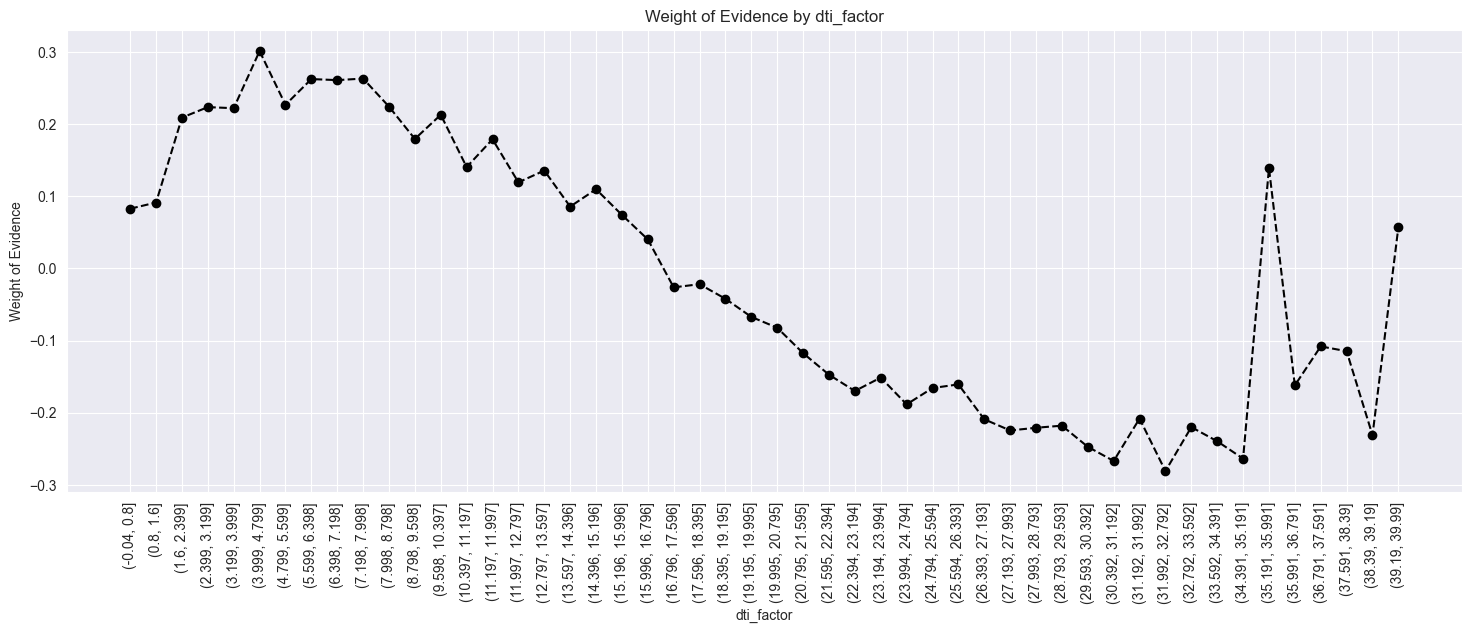

In [169]:
utils.plot_by_woe(df_temp, 90)

In [170]:
X_temp = X.loc[X['dti'] <= 35, : ]

X_temp['dti_factor'] = pd.cut(X_temp['dti'],50)
df_temp = utils.woe_ordered_continuous(X_temp, 'dti_factor', y[X_temp.index])
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.035, 0.7]",1694,0.891972,0.003661,1511.0,183.0,0.003677,0.003536,0.039226,0.027637
1,"(0.7, 1.4]",2057,0.894507,0.004446,1840.0,217.0,0.004478,0.004192,0.065809,0.027637
2,"(1.4, 2.1]",2522,0.908406,0.005451,2291.0,231.0,0.005575,0.004463,0.222511,0.027637
3,"(2.1, 2.8]",3201,0.911278,0.006918,2917.0,284.0,0.007098,0.005487,0.257522,0.027637
4,"(2.8, 3.5]",3946,0.906234,0.008528,3576.0,370.0,0.008702,0.007148,0.196682,0.027637
5,"(3.5, 4.2]",4814,0.911508,0.010404,4388.0,426.0,0.010678,0.008230,0.260375,0.027637
6,"(4.2, 4.9]",5735,0.911944,0.012395,5230.0,505.0,0.012727,0.009757,0.265793,0.027637
7,"(4.9, 5.6]",6682,0.909458,0.014442,6077.0,605.0,0.014788,0.011689,0.235223,0.027637
8,"(5.6, 6.3]",7418,0.911566,0.016032,6762.0,656.0,0.016455,0.012674,0.261098,0.027637
9,"(6.3, 7.0]",8204,0.911385,0.017731,7477.0,727.0,0.018195,0.014046,0.258845,0.027637


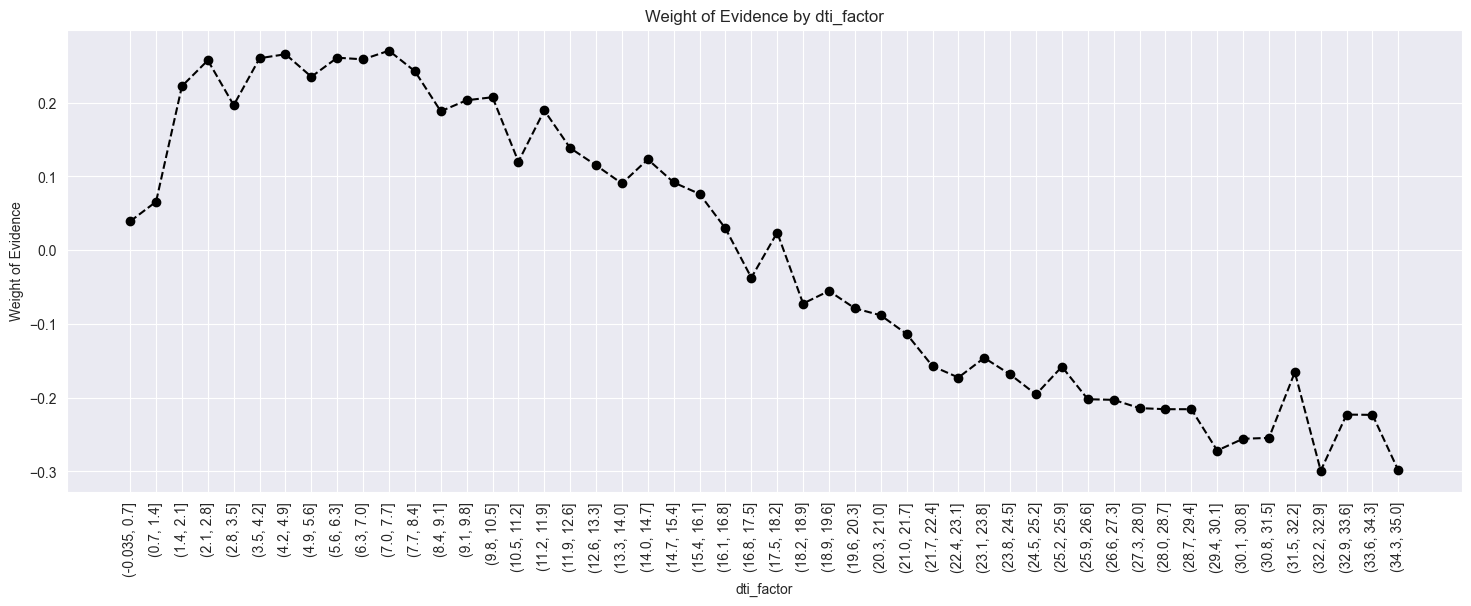

In [171]:
utils.plot_by_woe(df_temp, 90)

- dti:<7.7
- dti:7.7-10.5
- dti:10.6-14.0
- dti:14.1-17.5
- dti:17.6-18.8
- dti:18.9-23.1
- dti:23.2-30.1
- dti:>30.2



In [172]:
bins = [-float('inf'), 7.7, 10.6, 14.1, 17.6, 18.9, 23.2, 30.2, float('inf')]
labels = ['dti:<7.7', 'dti:7.7-10.5', 'dti:10.6-14.0', 
          'dti:14.1-17.5', 'dti:17.6-18.8', 'dti:18.9-23.1', 
          'dti:23.2-30.1', 'dti:>30.1']
X_temp['dti_factor'] = pd.cut(X['dti'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'dti_factor', y)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,dti:<7.7,55375,0.909670,0.119680,50373.0,5002.0,0.122582,0.096638,0.237803,0.025858
1,dti:7.7-10.5,46684,0.907442,0.100896,42363.0,4321.0,0.103090,0.083481,0.210974,0.025858
2,dti:10.6-14.0,71024,0.899893,0.153501,63914.0,7110.0,0.155533,0.137365,0.124221,0.025858
3,dti:14.1-17.5,75552,0.893570,0.163287,67511.0,8041.0,0.164287,0.155352,0.055922,0.025858
4,dti:17.6-18.8,27425,0.885105,0.059272,24274.0,3151.0,0.059070,0.060877,-0.030129,0.025858
5,dti:18.9-23.1,80663,0.876709,0.174333,70718.0,9945.0,0.172091,0.192137,-0.110185,0.025858
6,dti:23.2-30.1,82702,0.867452,0.178740,71740.0,10962.0,0.174578,0.211785,-0.193201,0.025858
7,dti:>30.1,23269,0.861275,0.050290,20041.0,3228.0,0.048769,0.062365,-0.245898,0.025858


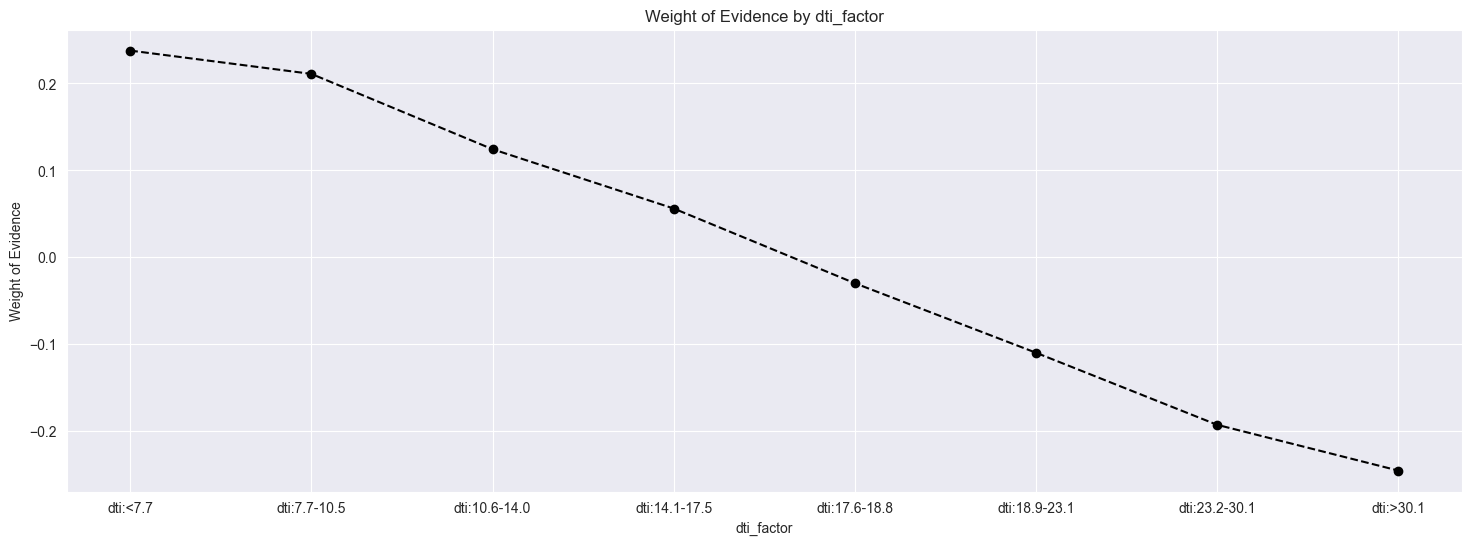

In [173]:
utils.plot_by_woe(df_temp)

In [174]:
X['dti:<7.7'] = np.where((X['dti'] < 7.7), 1, 0)
X['dti:7.7-10.5'] = np.where((X['dti'].between(7.7, 10.5)), 1, 0)
X['dti:10.6-14.0'] = np.where((X['dti'].between(10.6, 14.0)), 1, 0)
X['dti:14.1-17.5'] = np.where((X['dti'].between(14.1, 17.5)), 1, 0)
X['dti:17.6-18.8'] = np.where((X['dti'].between(17.6, 18.8)), 1, 0)
X['dti:18.9-23.1'] = np.where((X['dti'].between(18.9, 23.1)), 1, 0)
X['dti:23.2-30.1'] = np.where((X['dti'].between(23.2, 30.1)), 1, 0)
X['dti:>30.1'] = np.where((X['dti'] > 30.3), 1, 0)

#### **4. WoE of Inq Last 6 Months Features**

In [175]:
X['dti'].unique()

array([27.65,  1.  ,  8.72, ..., 38.95, 39.82, 39.14])

In [176]:
df_temp = utils.woe_ordered_continuous(X, 'inq_last_6mths', y)
df_temp

,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,241527,0.906304,0.517981,218897.0,22630.0,0.528610,0.433641,0.198034,inf
1,1.0,130148,0.881719,0.279117,114754.0,15394.0,0.277117,0.294983,-0.062478,inf
2,2.0,57825,0.860942,0.124012,49784.0,8041.0,0.120222,0.154083,-0.248151,inf
3,3.0,25126,0.838096,0.053885,21058.0,4068.0,0.050853,0.077952,-0.427162,inf
4,4.0,7241,0.842701,0.015529,6102.0,1139.0,0.014736,0.021826,-0.392825,inf
5,5.0,2768,0.822254,0.005936,2276.0,492.0,0.005496,0.009428,-0.539595,inf
6,6.0,1188,0.781987,0.002548,929.0,259.0,0.002243,0.004963,-0.794010,inf
7,7.0,195,0.651282,0.000418,127.0,68.0,0.000307,0.001303,-1.446611,inf
8,8.0,122,0.622951,0.000262,76.0,46.0,0.000184,0.000881,-1.569199,inf
9,9.0,50,0.640000,0.000107,32.0,18.0,0.000077,0.000345,-1.495927,inf


- inq_last_6mths:0
- inq_last_6mths:1-2
- inq_last_6mths:3-6
- inq_last_6mths:>6

In [177]:
bins = [0, 1, 3, 7, float('inf')]
labels = ['inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6']
X['inq_last_6mths_factor'] = pd.cut(X['inq_last_6mths'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X, 'inq_last_6mths_factor', y)
df_temp

,inq_last_6mths_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,inq_last_6mths:0,241527,0.906304,0.517981,218897.0,22630.0,0.528610,0.433641,0.198034,0.046736
1,inq_last_6mths:1-2,187973,0.875328,0.403129,164538.0,23435.0,0.397340,0.449067,-0.122380,0.046736
2,inq_last_6mths:3-6,36323,0.835972,0.077899,30365.0,5958.0,0.073328,0.114169,-0.442735,0.046736
3,inq_last_6mths:>6,462,0.647186,0.000991,299.0,163.0,0.000722,0.003123,-1.464597,0.046736


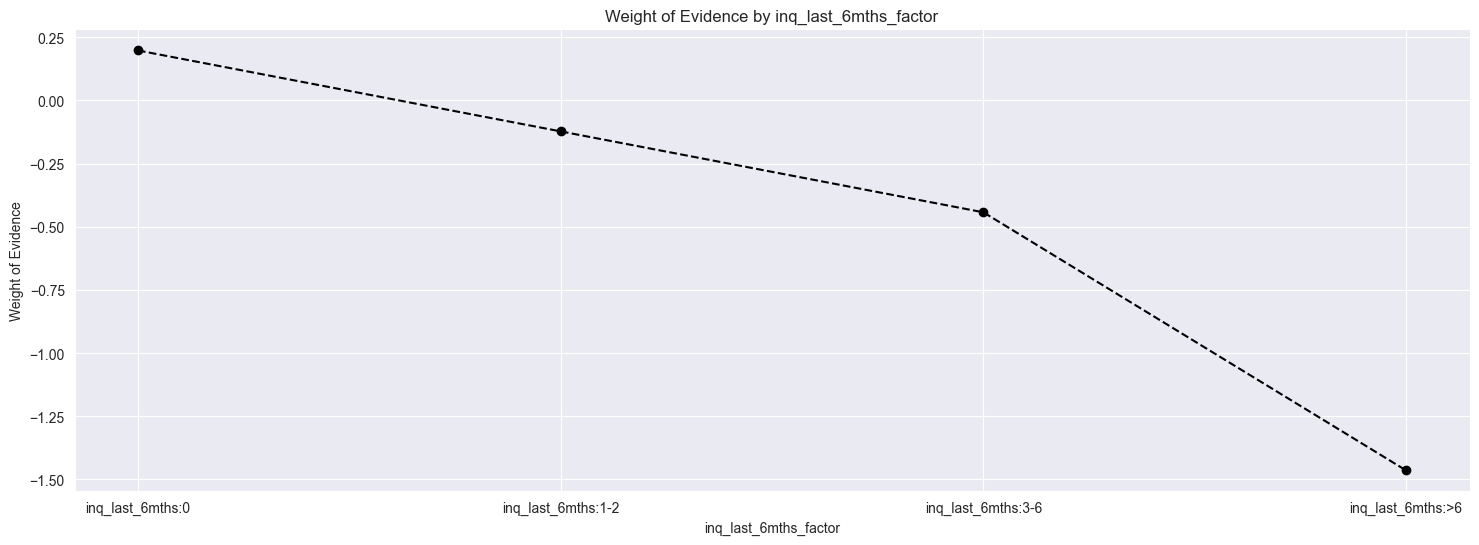

In [178]:
utils.plot_by_woe(df_temp)

In [179]:
X['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
X['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'].between(1, 2)), 1, 0)
X['inq_last_6mths:3-6'] = np.where((X['inq_last_6mths'].between(3, 6)), 1, 0)
X['inq_last_6mths:>6'] = np.where((X['inq_last_6mths'] > 6), 1, 0)

#### **5. WoE of Revol Util Features**

In [180]:
X['revol_util'].unique()

array([ 83.7,   9.4,  98.5, ..., 111.3, 113. , 141.8])

In [181]:
X['revol_util_factor'] = pd.cut(X['revol_util'],50)
X['revol_util_factor'].unique()

[(71.384, 89.23], (-0.892, 17.846], (89.23, 107.076], (17.846, 35.692], (53.538, 71.384], ..., (142.768, 160.614], (178.46, 196.306], (160.614, 178.46], (356.92, 374.766], (874.454, 892.3]]
Length: 13
Categories (50, interval[float64, right]): [(-0.892, 17.846] < (17.846, 35.692] < (35.692, 53.538] < (53.538, 71.384] ... (820.916, 838.762] < (838.762, 856.608] < (856.608, 874.454] < (874.454, 892.3]]

In [182]:
df_temp = utils.woe_ordered_continuous(X, 'revol_util_factor', y)
df_temp

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.892, 17.846]",31997,0.914711,0.068621,29268.0,2729.0,0.070679,0.052294,0.301269,inf
1,"(17.846, 35.692]",66009,0.908331,0.141564,59958.0,6051.0,0.144791,0.115951,0.222130,inf
2,"(35.692, 53.538]",107546,0.896454,0.230644,96410.0,11136.0,0.232819,0.213391,0.087136,inf
3,"(53.538, 71.384]",122550,0.885018,0.262822,108459.0,14091.0,0.261916,0.270015,-0.030455,inf
4,"(71.384, 89.23]",101375,0.872513,0.217410,88451.0,12924.0,0.213599,0.247653,-0.147928,inf
5,"(89.23, 107.076]",36668,0.857260,0.078639,31434.0,5234.0,0.075909,0.100295,-0.278577,inf
6,"(107.076, 124.922]",115,0.878261,0.000247,101.0,14.0,0.000244,0.000268,-0.095228,inf
7,"(124.922, 142.768]",16,0.625000,0.000034,10.0,6.0,0.000024,0.000115,-1.560465,inf
8,"(142.768, 160.614]",5,0.800000,0.000011,4.0,1.0,0.000010,0.000019,-0.684996,inf
9,"(160.614, 178.46]",1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,inf


In [183]:
X_temp = X.loc[X['revol_util'] <= 100, : ]

X_temp['revol_util_factor'] = pd.cut(X_temp['revol_util'],50)
df_temp = utils.woe_ordered_continuous(X_temp, 'revol_util_factor', y[X_temp.index])
df_temp

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.1, 2.0]",5278,0.883858,0.011351,4665.0,613.0,0.011296,0.011789,-0.042730,0.029594
1,"(2.0, 4.0]",2342,0.916311,0.005037,2146.0,196.0,0.005196,0.003769,0.321038,0.029594
2,"(4.0, 6.0]",2556,0.922535,0.005497,2358.0,198.0,0.005710,0.003808,0.405093,0.029594
3,"(6.0, 8.0]",2808,0.920940,0.006039,2586.0,222.0,0.006262,0.004269,0.382982,0.029594
4,"(8.0, 10.0]",3341,0.924873,0.007185,3090.0,251.0,0.007482,0.004827,0.438265,0.029594
5,"(10.0, 12.0]",3440,0.921512,0.007398,3170.0,270.0,0.007676,0.005192,0.390856,0.029594
6,"(12.0, 14.0]",3756,0.915602,0.008078,3439.0,317.0,0.008327,0.006096,0.311826,0.029594
7,"(14.0, 16.0]",4316,0.922382,0.009282,3981.0,335.0,0.009639,0.006442,0.402949,0.029594
8,"(16.0, 18.0]",4667,0.920291,0.010037,4295.0,372.0,0.010400,0.007154,0.374104,0.029594
9,"(18.0, 20.0]",5238,0.917717,0.011265,4807.0,431.0,0.011639,0.008289,0.339512,0.029594


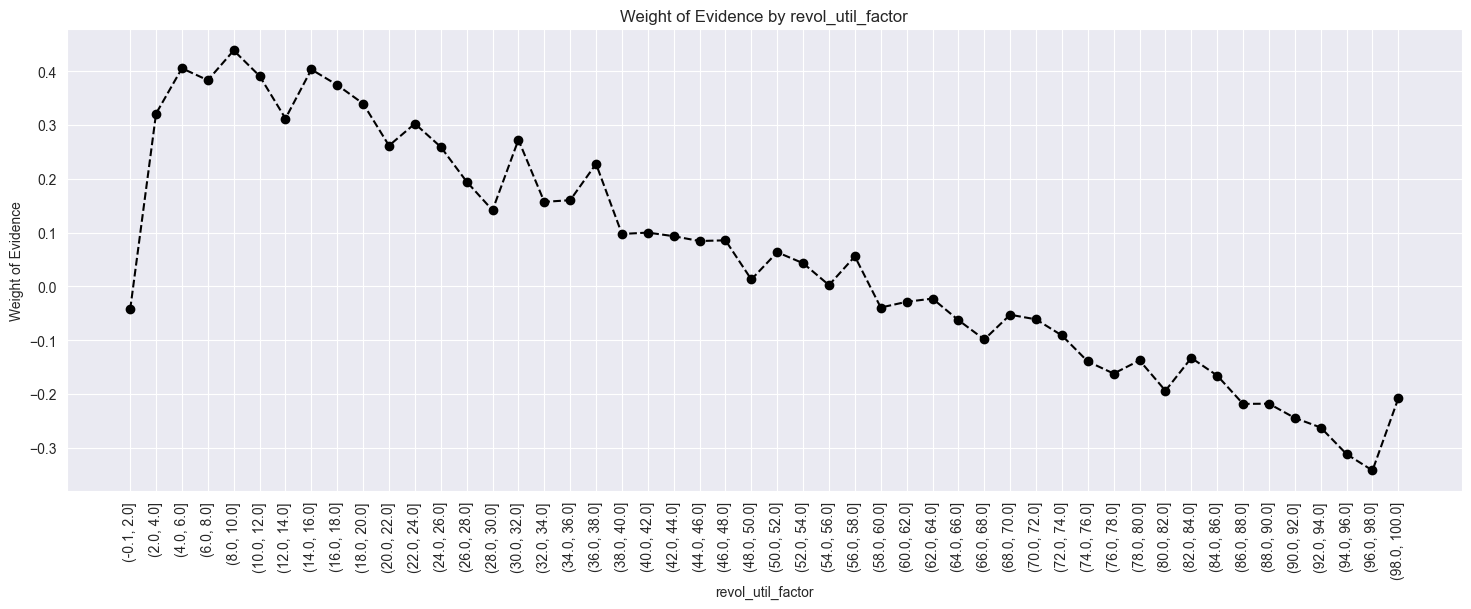

In [184]:
utils.plot_by_woe(df_temp, 90)

- revol_util:<14
- revol_util:14-30
- revol_util:31-40
- revol_util:41-50
- revol_util:51-60
- revol_util:61-68
- revol_util:69-82
- revol_util:>82

In [185]:
bins = [-float('inf'), 14, 31, 41, 51, 61, 69, 83, float('inf')]
labels = ['revol_util:<14', 'revol_util:14-30', 'revol_util:31-40', 'revol_util:41-50', 
          'revol_util:51-60', 'revol_util:61-68', 'revol_util:69-82', 'revol_util:>82']
X_temp['revol_util_factor'] = pd.cut(X['revol_util'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'revol_util_factor', y)
df_temp

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,revol_util:<14,23296,0.911959,0.050100,21245.0,2051.0,0.051441,0.039443,0.265586,0.025506
1,revol_util:14-30,52625,0.912247,0.113174,48007.0,4618.0,0.116241,0.088809,0.269177,0.025506
2,revol_util:31-40,50215,0.903356,0.107991,45362.0,4853.0,0.109837,0.093329,0.162869,0.025506
3,revol_util:41-50,61779,0.895159,0.132860,55302.0,6477.0,0.133905,0.124560,0.072343,0.025506
4,revol_util:51-60,68786,0.889352,0.147929,61175.0,7611.0,0.148126,0.146368,0.011935,0.025506
5,revol_util:61-68,55314,0.881621,0.118957,48766.0,6548.0,0.118079,0.125925,-0.064335,0.025506
6,revol_util:69-82,86272,0.875777,0.185534,75555.0,10717.0,0.182945,0.206100,-0.119179,0.025506
7,revol_util:>82,66706,0.863221,0.143456,57582.0,9124.0,0.139426,0.175465,-0.229907,0.025506


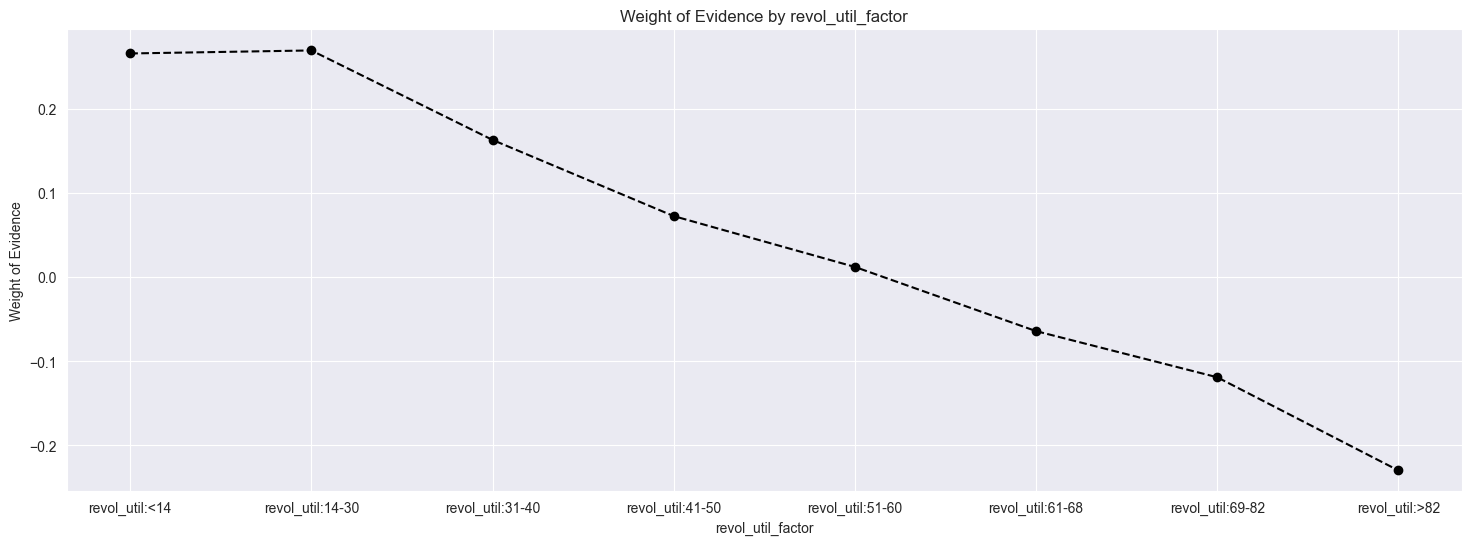

In [186]:
utils.plot_by_woe(df_temp)

In [187]:
X['revol_util:<14'] = np.where((X['revol_util'] < 14), 1, 0)
X['revol_util:14-30'] = np.where((X['revol_util'].between(14, 30)), 1, 0)
X['revol_util:31-40'] = np.where((X['revol_util'].between(31, 40)), 1, 0)
X['revol_util:41-50'] = np.where((X['revol_util'].between(41, 50)), 1, 0)
X['revol_util:51-60'] = np.where((X['revol_util'].between(51, 60)), 1, 0)
X['revol_util:61-68'] = np.where((X['revol_util'].between(61, 68)), 1, 0)
X['revol_util:69-82'] = np.where((X['revol_util'].between(69, 82)), 1, 0)
X['revol_util:>82'] = np.where((X['revol_util'] > 82), 1, 0)

#### **6. WoE of Total Current Balance Features**

In [188]:
loan['tot_cur_bal'].unique()

array([ 81539., 114834.,  14123., ..., 294998., 591610.,  57477.])

In [189]:
X['tot_cur_bal_factor'] = pd.cut(X['tot_cur_bal'],50)
X['tot_cur_bal_factor'].unique()

[(-8000.078, 160001.56], (160001.56, 320003.12], (320003.12, 480004.68], (640006.24, 800007.8], (480004.68, 640006.24], ..., (3520034.32, 3680035.88], (4000039.0, 4160040.56], (3680035.88, 3840037.44], (2720026.52, 2880028.08], (3200031.2, 3360032.76]]
Length: 28
Categories (50, interval[float64, right]): [(-8000.078, 160001.56] < (160001.56, 320003.12] < (320003.12, 480004.68] < (480004.68, 640006.24] ... (7360071.76, 7520073.32] < (7520073.32, 7680074.88] < (7680074.88, 7840076.44] < (7840076.44, 8000078.0]]

In [190]:
df_temp = utils.woe_ordered_continuous(X, 'tot_cur_bal_factor', y)
df_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-8000.078, 160001.56]",329495,0.876699,0.706639,288868.0,40627.0,0.697582,0.778504,-0.109754,inf
1,"(160001.56, 320003.12]",93482,0.909020,0.200483,84977.0,8505.0,0.205209,0.162975,0.230436,inf
2,"(320003.12, 480004.68]",31088,0.925470,0.066672,28771.0,2317.0,0.069479,0.044399,0.447804,inf
3,"(480004.68, 640006.24]",8112,0.937007,0.017397,7601.0,511.0,0.018356,0.009792,0.628375,inf
4,"(640006.24, 800007.8]",2407,0.945160,0.005162,2275.0,132.0,0.005494,0.002529,0.775643,inf
5,"(800007.8, 960009.36]",836,0.936603,0.001793,783.0,53.0,0.001891,0.001016,0.621550,inf
6,"(960009.36, 1120010.92]",397,0.944584,0.000851,375.0,22.0,0.000906,0.000422,0.764593,inf
7,"(1120010.92, 1280012.48]",186,0.962366,0.000399,179.0,7.0,0.000432,0.000134,1.170185,inf
8,"(1280012.48, 1440014.04]",106,0.971698,0.000227,103.0,3.0,0.000249,0.000057,1.464826,inf
9,"(1440014.04, 1600015.6]",56,0.982143,0.000120,55.0,1.0,0.000133,0.000019,1.936042,inf


In [191]:
X_temp = X.loc[X['tot_cur_bal'] <= 800000, : ]

X_temp['tot_cur_bal_factor'] = pd.cut(X_temp['tot_cur_bal'],50)
df_temp = utils.woe_ordered_continuous(X_temp, 'tot_cur_bal_factor', y[X_temp.index])
df_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-799.933, 15998.66]",48480,0.886200,0.104351,42963.0,5517.0,0.104155,0.105909,-0.016700,0.054882
1,"(15998.66, 31997.32]",62672,0.879755,0.134899,55136.0,7536.0,0.133666,0.144667,-0.079094,0.054882
2,"(31997.32, 47995.98]",43163,0.881727,0.092907,38058.0,5105.0,0.092264,0.098000,-0.060315,0.054882
3,"(47995.98, 63994.64]",25464,0.883522,0.054810,22498.0,2966.0,0.054542,0.056938,-0.042993,0.054882
4,"(63994.64, 79993.3]",16793,0.885548,0.036146,14871.0,1922.0,0.036052,0.036896,-0.023159,0.054882
5,"(79993.3, 95991.96]",83686,0.852233,0.180131,71320.0,12366.0,0.172900,0.237388,-0.316979,0.054882
6,"(95991.96, 111990.62]",11953,0.893332,0.025728,10678.0,1275.0,0.025887,0.024476,0.056034,0.054882
7,"(111990.62, 127989.28]",11858,0.890707,0.025524,10562.0,1296.0,0.025605,0.024879,0.028775,0.054882
8,"(127989.28, 143987.94]",12619,0.895475,0.027162,11300.0,1319.0,0.027394,0.025321,0.078723,0.054882
9,"(143987.94, 159986.6]",12794,0.896592,0.027539,11471.0,1323.0,0.027809,0.025397,0.090715,0.054882


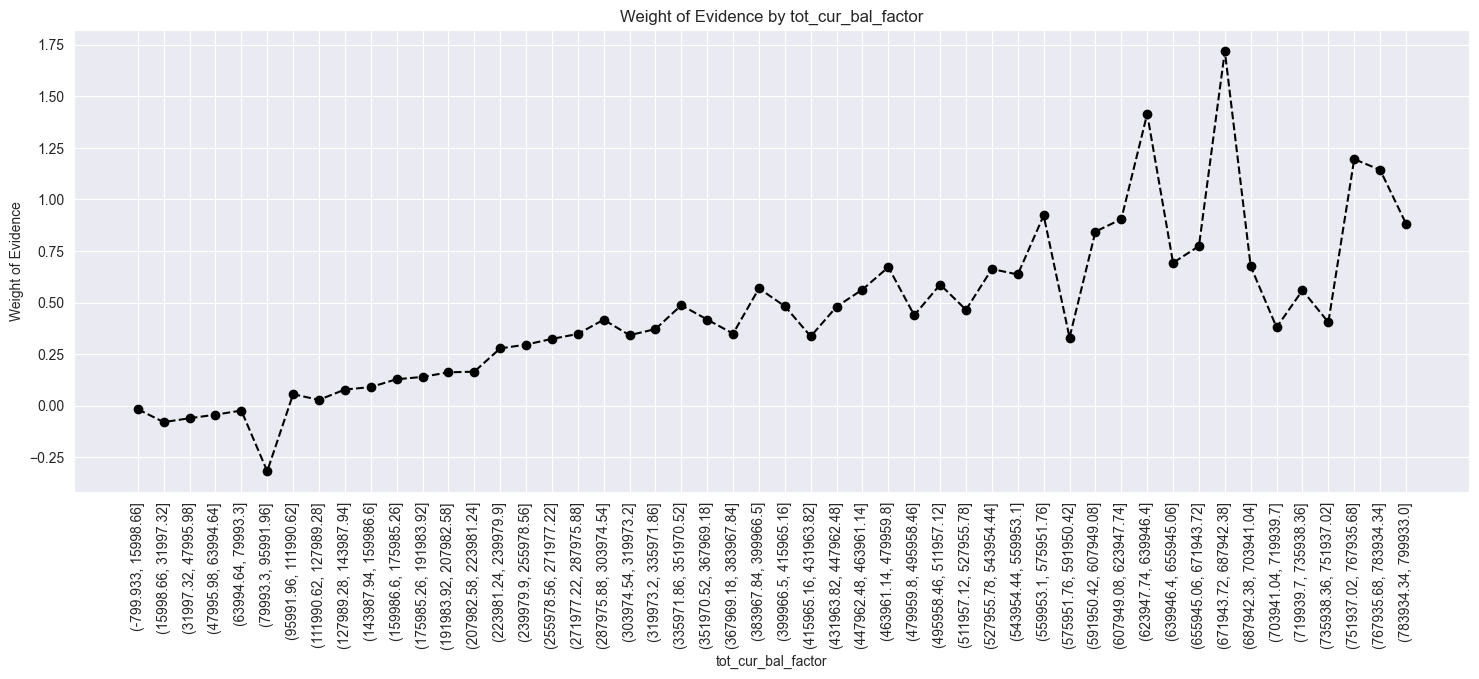

In [192]:
utils.plot_by_woe(df_temp, 90)

- tot_cur_bal:<20k
- tot_cur_bal:20k-40k
- tot_cur_bal:40k-80k
- tot_cur_bal:80k-120k
- tot_cur_bal:120k-240k
- tot_cur_bal:240k-360k
- tot_cur_bal:>360k

In [193]:
bins = [-float('inf'), 20000, 40000, 80000, 120000, 240000, 360000, float('inf')]
labels = ['tot_cur_bal:<20k', 'tot_cur_bal:20k-40k', 'tot_cur_bal:40k-80k', 'tot_cur_bal:80k-120k', 
          'tot_cur_bal:120k-240k', 'tot_cur_bal:240k-360k', 'tot_cur_bal:>360k']
X_temp['tot_cur_bal_factor'] = pd.cut(X['tot_cur_bal'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'tot_cur_bal_factor', y)
df_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,tot_cur_bal:<20k,64944,0.884393,0.139790,57436.0,7508.0,0.139241,0.144130,-0.034503,0.046621
1,tot_cur_bal:20k-40k,70778,0.881107,0.152347,62363.0,8415.0,0.151186,0.161541,-0.066249,0.046621
2,tot_cur_bal:40k-80k,60856,0.882937,0.130990,53732.0,7124.0,0.130262,0.136758,-0.048666,0.046621
3,tot_cur_bal:80k-120k,101512,0.859554,0.218501,87255.0,14257.0,0.211531,0.273689,-0.257619,0.046621
4,tot_cur_bal:120k-240k,88784,0.900286,0.191104,79931.0,8853.0,0.193776,0.169949,0.131202,0.046621
5,tot_cur_bal:240k-360k,47594,0.919297,0.102444,43753.0,3841.0,0.106070,0.073735,0.363622,0.046621
6,tot_cur_bal:>360k,30116,0.930469,0.064824,28022.0,2094.0,0.067933,0.040198,0.524708,0.046621


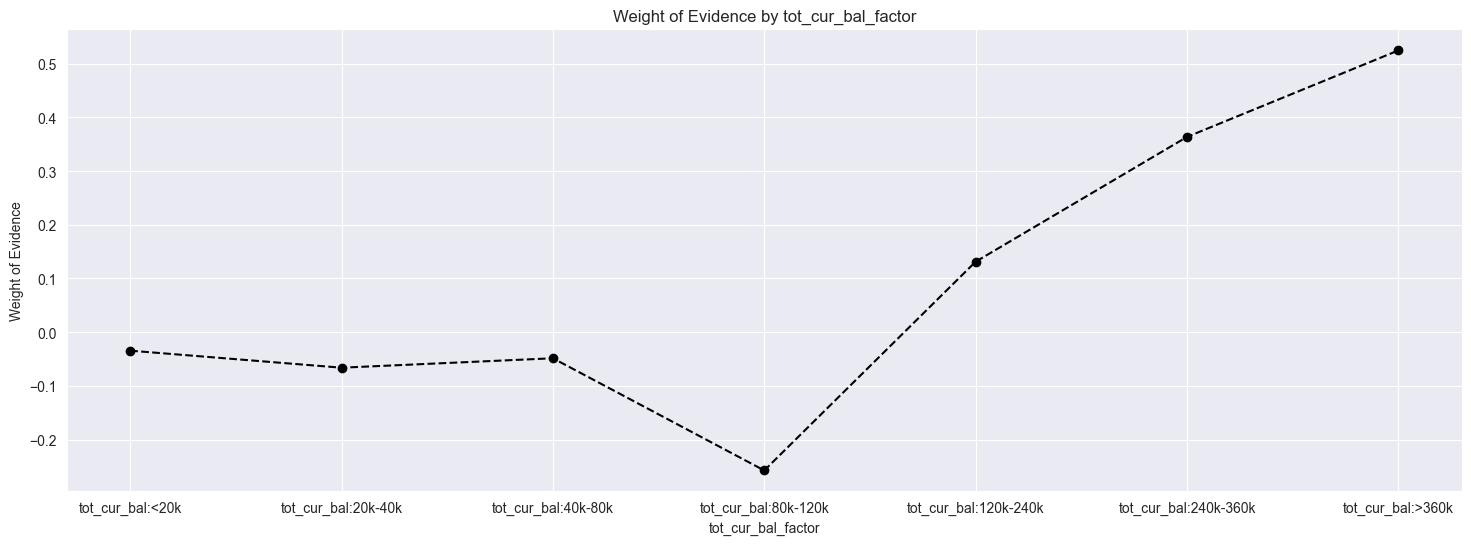

In [194]:
utils.plot_by_woe(df_temp)

In [195]:
X['tot_cur_bal:<20k'] = np.where((X['tot_cur_bal'] < 20000), 1, 0)
X['tot_cur_bal:20k-40k'] = np.where((X['tot_cur_bal'].between(20000, 40000, inclusive='left')), 1, 0)
X['tot_cur_bal:40k-80k'] = np.where((X['tot_cur_bal'].between(40000, 80000, inclusive='left')), 1, 0)
X['tot_cur_bal:80k-120k'] = np.where((X['tot_cur_bal'].between(80000, 120000, inclusive='left')), 1, 0)
X['tot_cur_bal:120k-240k'] = np.where((X['tot_cur_bal'].between(120000, 240000, inclusive='left')), 1, 0)
X['tot_cur_bal:240k-360k'] = np.where((X['tot_cur_bal'].between(240000, 360000, inclusive='left')), 1, 0)
X['tot_cur_bal:>360k'] = np.where((X['tot_cur_bal'] > 360000), 1, 0)

#### **7. WoE of Total Revolving High Credit Features**

In [196]:
X['total_rev_hi_lim'].unique()

array([  5000.,   2500.,   2400., ..., 102342.,  71491., 479500.])

In [197]:
X['total_rev_hi_lim_factor'] = pd.cut(X['total_rev_hi_lim'], 50)
X['total_rev_hi_lim_factor'].unique()

[(-9999.999, 199999.98], (199999.98, 399999.96], (399999.96, 599999.94], (999999.9, 1199999.88], (599999.94, 799999.92], ..., (9799999.02, 9999999.0], (1999999.8, 2199999.78], (799999.92, 999999.9], (1399999.86, 1599999.84], (1199999.88, 1399999.86]]
Length: 11
Categories (50, interval[float64, right]): [(-9999.999, 199999.98] < (199999.98, 399999.96] < (399999.96, 599999.94] < (599999.94, 799999.92] ... (9199999.08, 9399999.06] < (9399999.06, 9599999.04] < (9599999.04, 9799999.02] < (9799999.02, 9999999.0]]

In [198]:
df_temp = utils.woe_ordered_continuous(X, 'total_rev_hi_lim_factor', y)
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-9999.999, 199999.98]",464870,0.887893,0.996965,412755.0,52115.0,0.996754,0.998639,-0.001889,inf
1,"(199999.98, 399999.96]",1264,0.948576,0.002711,1199.0,65.0,0.002895,0.001246,0.843565,inf
2,"(399999.96, 599999.94]",103,0.970874,0.000221,100.0,3.0,0.000241,0.000057,1.435267,inf
3,"(599999.94, 799999.92]",31,0.935484,0.000066,29.0,2.0,0.000070,0.000038,0.602858,inf
4,"(799999.92, 999999.9]",6,1.000000,0.000013,6.0,0.0,0.000014,0.000000,inf,inf
5,"(999999.9, 1199999.88]",5,1.000000,0.000011,5.0,0.0,0.000012,0.000000,inf,inf
6,"(1199999.88, 1399999.86]",1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,inf
7,"(1399999.86, 1599999.84]",1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,inf
8,"(1599999.84, 1799999.82]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
9,"(1799999.82, 1999999.8]",1,0.000000,0.000002,0.0,1.0,0.000000,0.000019,-inf,inf


In [199]:
X_temp = X.loc[X['total_rev_hi_lim'] <= 200000, : ]

X_temp['total_rev_hi_lim_factor'] = pd.cut(X_temp['total_rev_hi_lim'],50)
df_temp = utils.woe_ordered_continuous(X_temp, 'total_rev_hi_lim_factor', y[X_temp.index])
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-200.0, 4000.0]",17308,0.859198,0.037232,14871.0,2437.0,0.036028,0.046762,-0.260763,0.042723
1,"(4000.0, 8000.0]",48503,0.872029,0.104336,42296.0,6207.0,0.102472,0.119102,-0.150394,0.042723
2,"(8000.0, 12000.0]",59789,0.875529,0.128614,52347.0,7442.0,0.126822,0.142800,-0.118654,0.042723
3,"(12000.0, 16000.0]",56443,0.875007,0.121416,49388.0,7055.0,0.119654,0.135374,-0.123438,0.042723
4,"(16000.0, 20000.0]",50192,0.877510,0.107969,44044.0,6148.0,0.106707,0.117970,-0.100346,0.042723
5,"(20000.0, 24000.0]",40342,0.885504,0.086781,35723.0,4619.0,0.086547,0.088631,-0.023792,0.042723
6,"(24000.0, 28000.0]",35029,0.884810,0.075352,30994.0,4035.0,0.075090,0.077425,-0.030621,0.042723
7,"(28000.0, 32000.0]",27456,0.892264,0.059061,24498.0,2958.0,0.059352,0.056759,0.044669,0.042723
8,"(32000.0, 36000.0]",23585,0.889591,0.050734,20981.0,2604.0,0.050831,0.049966,0.017160,0.042723
9,"(36000.0, 40000.0]",18089,0.906462,0.038912,16397.0,1692.0,0.039725,0.032467,0.201778,0.042723


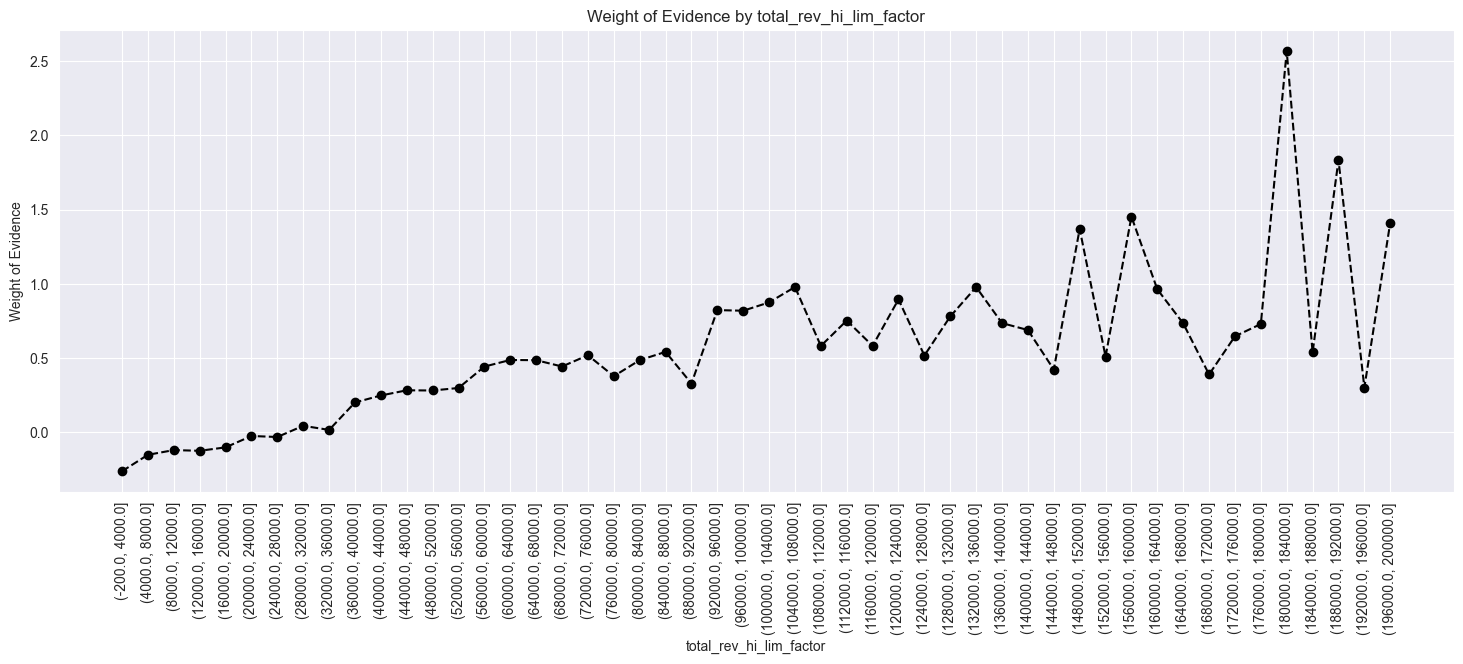

In [200]:
utils.plot_by_woe(df_temp, 90)

- total_rev_hi_lim:<5k
- total_rev_hi_lim:5k-10k
- total_rev_hi_lim:10k-20k
- total_rev_hi_lim:20k-40k
- total_rev_hi_lim:40k-65k
- total_rev_hi_lim:65k-95k
- total_rev_hi_lim:>95k

In [201]:
bins = [-float('inf'), 5000, 10000, 20000, 40000, 65000, 95000, float('inf')]
labels = ['total_rev_hi_lim:<5k', 'total_rev_hi_lim:5k-10k', 'total_rev_hi_lim:10k-20k', 'total_rev_hi_lim:20k-40k', 
          'total_rev_hi_lim:40k-65k', 'total_rev_hi_lim:65k-95k', 'total_rev_hi_lim:>95k']
X_temp['total_rev_hi_lim_factor'] = pd.cut(X['total_rev_hi_lim'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'total_rev_hi_lim_factor', y)
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,total_rev_hi_lim:<5k,24192,0.863137,0.052040,20881.0,3311.0,0.050589,0.063533,-0.227819,0.038263
1,total_rev_hi_lim:5k-10k,65653,0.873060,0.141228,57319.0,8334.0,0.138868,0.159916,-0.141120,0.038263
2,total_rev_hi_lim:10k-20k,138316,0.876717,0.297535,121264.0,17052.0,0.293790,0.327199,-0.107706,0.038263
3,total_rev_hi_lim:20k-40k,148149,0.888821,0.318687,131678.0,16471.0,0.319020,0.316051,0.009350,0.038263
4,total_rev_hi_lim:40k-65k,59127,0.915876,0.127190,54153.0,4974.0,0.131198,0.095443,0.318180,0.038263
5,total_rev_hi_lim:65k-95k,19663,0.926563,0.042298,18219.0,1444.0,0.044140,0.027708,0.465639,0.038263
6,total_rev_hi_lim:>95k,9773,0.945871,0.021023,9244.0,529.0,0.022396,0.010151,0.791333,0.038263


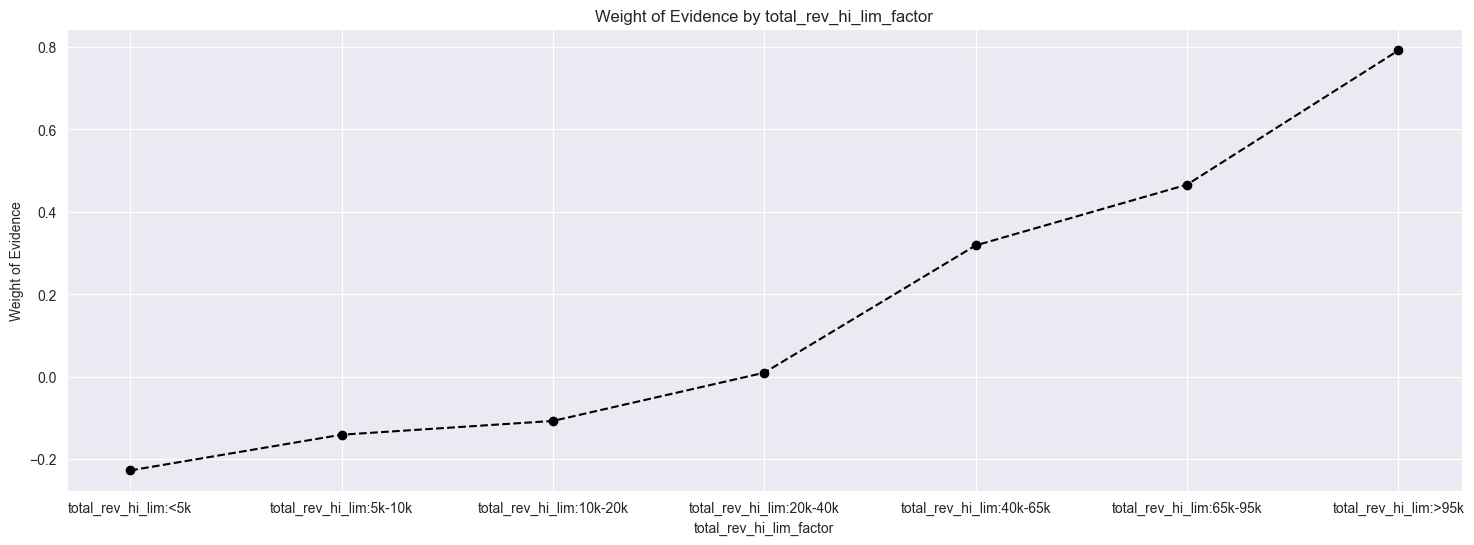

In [202]:
utils.plot_by_woe(df_temp)

In [203]:
X['total_rev_hi_lim:<5k'] = np.where((X['total_rev_hi_lim'] < 5000), 1, 0)
X['total_rev_hi_lim:5k-10k'] = np.where((X['total_rev_hi_lim'].between(5000, 10000, inclusive='left')), 1, 0)
X['total_rev_hi_lim:10k-20k'] = np.where((X['total_rev_hi_lim'].between(10000, 20000, inclusive='left')), 1, 0)
X['total_rev_hi_lim:20k-40k'] = np.where((X['total_rev_hi_lim'].between(20000, 40000, inclusive='left')), 1, 0)
X['total_rev_hi_lim:40k-65k'] = np.where((X['total_rev_hi_lim'].between(40000, 65000, inclusive='left')), 1, 0)
X['total_rev_hi_lim:65k-95k'] = np.where((X['total_rev_hi_lim'].between(65000, 95000, inclusive='left')), 1, 0)
X['total_rev_hi_lim:>95k'] = np.where((X['total_rev_hi_lim'] > 95000), 1, 0)

#### **8. WoE of Term Features**

In [204]:
loan['term_int'].unique()

array([36, 60])

In [205]:
df_temp = utils.woe_ordered_continuous(X, 'term_int', y)
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,36,337953,0.900640,0.724778,304374.0,33579.0,0.735027,0.643448,0.133066,0.039371
1,60,128332,0.855009,0.275222,109725.0,18607.0,0.264973,0.356552,-0.296851,0.039371


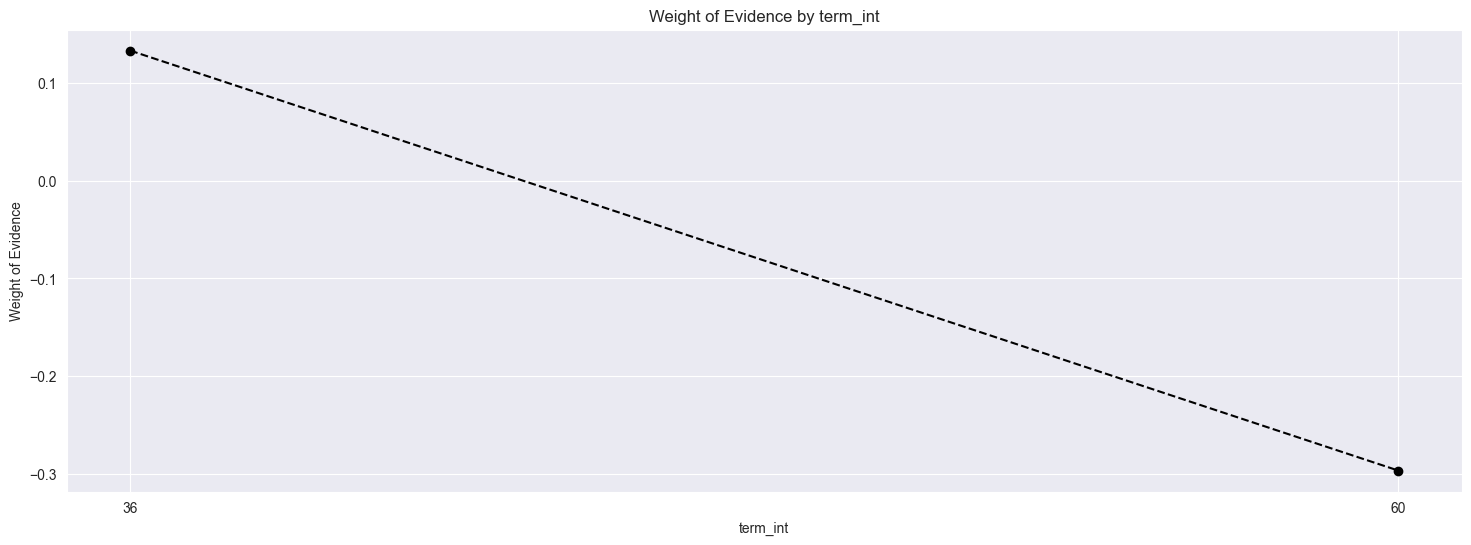

In [206]:
utils.plot_by_woe(df_temp)

- 'term:36'
- 'term:60'

In [207]:
X['term:36'] = np.where((X['term_int'] == 36), 1, 0)
X['term:60'] = np.where((X['term_int'] == 60), 1, 0)

#### **9. WoE of Months Since Issue Date**

In [208]:
X['mths_since_issue_d'].unique()

array([104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79])

In [209]:
X['mths_since_issue_d_factor'] = pd.cut(X['mths_since_issue_d'],50)
X['mths_since_issue_d_factor'].unique()

[(102.2, 104.0], (104.0, 105.8], (105.8, 107.6], (107.6, 109.4], (109.4, 111.2], ..., (69.8, 71.6], (71.6, 73.4], (73.4, 75.2], (75.2, 77.0], (77.0, 78.8]]
Length: 50
Categories (50, interval[float64, right]): [(67.91, 69.8] < (69.8, 71.6] < (71.6, 73.4] < (73.4, 75.2] ... (150.8, 152.6] < (152.6, 154.4] < (154.4, 156.2] < (156.2, 158.0]]

In [210]:
df_temp = utils.woe_ordered_continuous(X, 'mths_since_issue_d_factor', y)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(67.91, 69.8]",35361,0.939538,0.075836,33223.0,2138.0,0.080230,0.040969,0.672081,0.10243
1,"(69.8, 71.6]",49388,0.924395,0.105918,45654.0,3734.0,0.110249,0.071552,0.432320,0.10243
2,"(71.6, 73.4]",48120,0.913986,0.103199,43981.0,4139.0,0.106209,0.079312,0.292013,0.10243
3,"(73.4, 75.2]",36278,0.905011,0.077802,32832.0,3446.0,0.079285,0.066033,0.182899,0.10243
4,"(75.2, 77.0]",35584,0.899000,0.076314,31990.0,3594.0,0.077252,0.068869,0.114867,0.10243
5,"(77.0, 78.8]",15269,0.895671,0.032746,13676.0,1593.0,0.033026,0.030525,0.078733,0.10243
6,"(78.8, 80.6]",30648,0.894088,0.065728,27402.0,3246.0,0.066173,0.062201,0.061902,0.10243
7,"(80.6, 82.4]",28790,0.885446,0.061743,25492.0,3298.0,0.061560,0.063197,-0.026242,0.10243
8,"(82.4, 84.2]",25661,0.877869,0.055033,22527.0,3134.0,0.054400,0.060054,-0.098886,0.10243
9,"(84.2, 86.0]",22809,0.865930,0.048916,19751.0,3058.0,0.047696,0.058598,-0.205848,0.10243


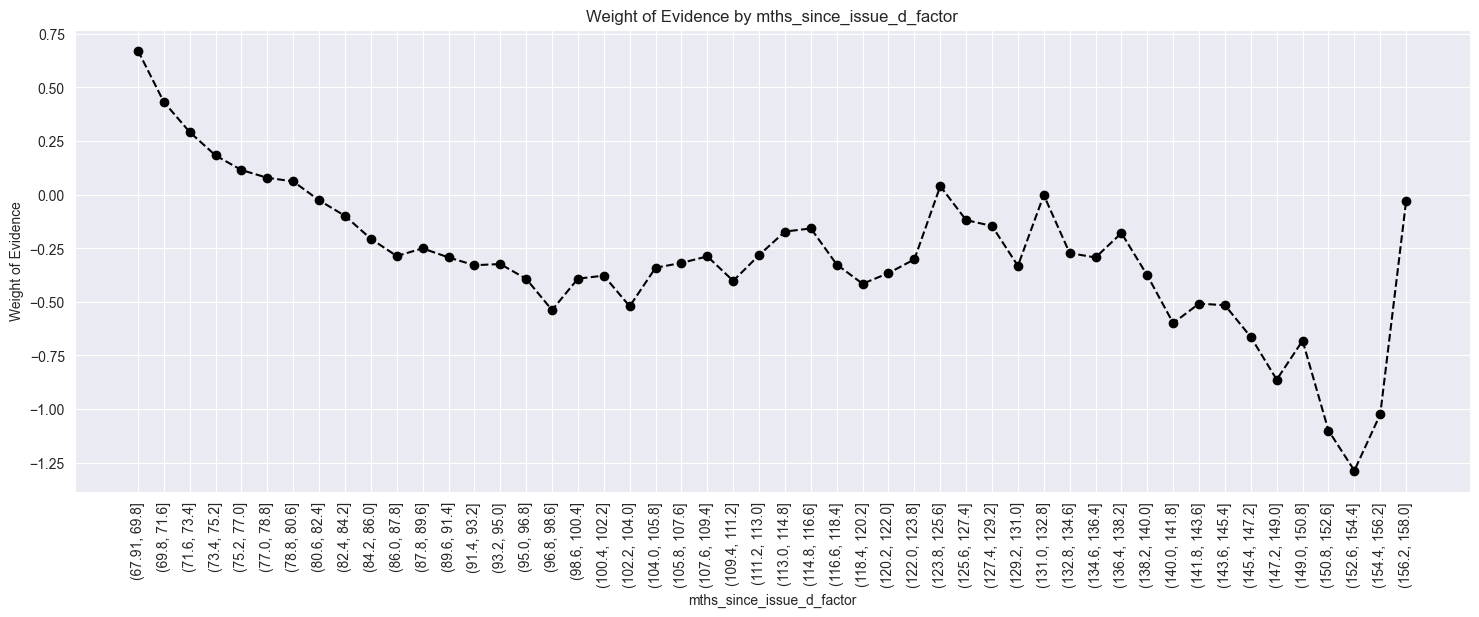

In [211]:
utils.plot_by_woe(df_temp, 90)

- mths_since_issue_d:<70
- mths_since_issue_d:70-75 
- mths_since_issue_d:75-80 
- mths_since_issue_d:80-85
- mths_since_issue_d:85-95
- mths_since_issue_d:>95

In [212]:
bins = [-float('inf'), 70, 75, 80, 85, 95, float('inf')]
labels = ['mths_since_issue_d:<70', 'mths_since_issue_d:70-75', 'mths_since_issue_d:75-80', 
          'mths_since_issue_d:80-85', 'mths_since_issue_d:85-95', 'mths_since_issue_d:>95']
X_temp['mths_since_issue_d_factor'] = pd.cut(X['mths_since_issue_d'], bins=bins, labels=labels, right=False)

df_temp = utils.woe_ordered_continuous(X_temp, 'mths_since_issue_d_factor', y)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,mths_since_issue_d:<70,35122,0.939411,0.075552,32994.0,2128.0,0.079935,0.040833,0.671735,0.094218
1,mths_since_issue_d:70-75,114241,0.917210,0.245747,104783.0,9458.0,0.253861,0.181483,0.335622,0.094218
2,mths_since_issue_d:75-80,85356,0.898308,0.183611,76676.0,8680.0,0.185765,0.166555,0.109159,0.094218
3,mths_since_issue_d:80-85,69257,0.884402,0.148980,61251.0,8006.0,0.148394,0.153622,-0.034620,0.094218
4,mths_since_issue_d:85-95,83713,0.858409,0.180077,71860.0,11853.0,0.174097,0.227439,-0.267270,0.094218
5,mths_since_issue_d:>95,77184,0.844657,0.166032,65194.0,11990.0,0.157947,0.230068,-0.376114,0.094218


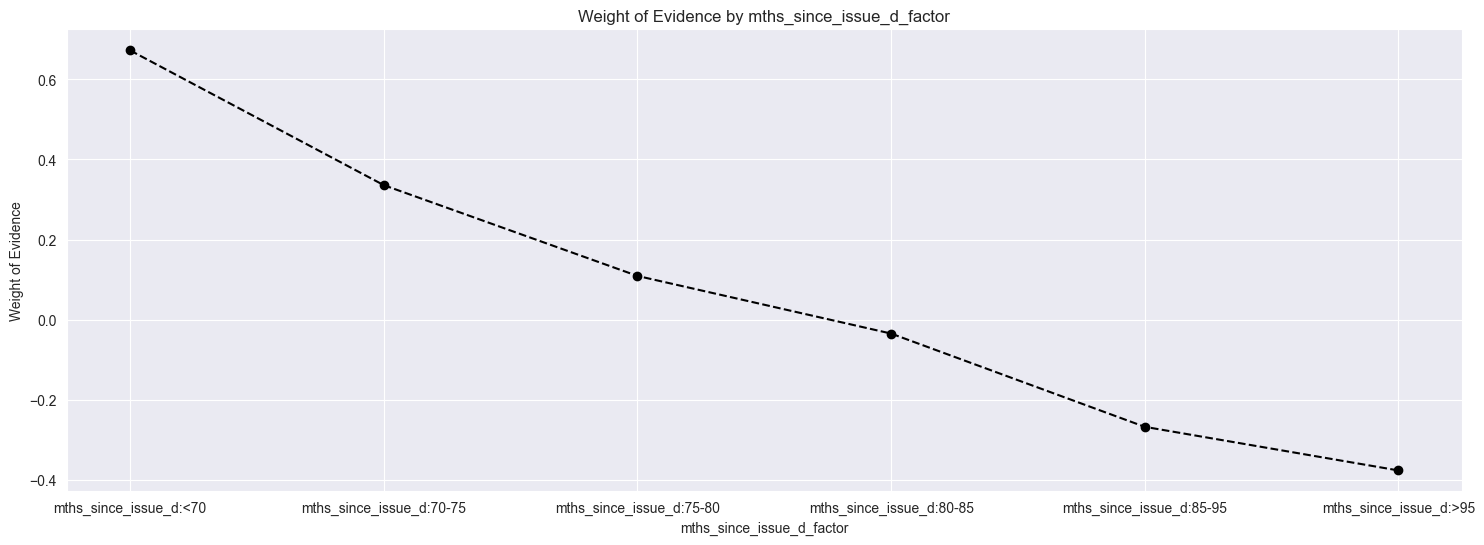

In [213]:
utils.plot_by_woe(df_temp)

In [214]:
X['mths_since_issue_d:<70'] = np.where((X['mths_since_issue_d'] < 70), 1, 0)
X['mths_since_issue_d:70-75'] = np.where((X['mths_since_issue_d'].between(70, 75, inclusive='left')), 1, 0)
X['mths_since_issue_d:75-80'] = np.where((X['mths_since_issue_d'].between(75, 80, inclusive='left')), 1, 0)
X['mths_since_issue_d:80-85'] = np.where((X['mths_since_issue_d'].between(80, 85, inclusive='left')), 1, 0)
X['mths_since_issue_d:85-95'] = np.where((X['mths_since_issue_d'].between(85, 95, inclusive='left')), 1, 0)
X['mths_since_issue_d:>95'] = np.where((X['mths_since_issue_d'] > 95), 1, 0)

### **Feature Selection**

In [216]:
X = X[config_data['selection_columns']]

Now we must remove 1 dummy variable for each original variable, otherwise we will get into the dummy variable trap. The dummy variables to be removed are those with the lowest WoE.

In [217]:
X.drop(columns=config_data['ref_columns'], axis=1, inplace=True)

In [218]:
print(f'Shape of predictive features (X): {X.shape}')

X = X.astype(int)
X.sample(5)

Shape of predictive features (X): (466285, 62)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:Not Verified,verification_status:Source Verified,purpose:other_renewable_energy_vacation_medical,purpose:debt_consolidation,purpose:major_purchase_car_home_improvement,purpose:credit_card,initial_list_status:w,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.026-15.74,int_rate:15.75-20.281,annual_inc:20k-30k,annual_inc:30k-40k,annual_inc:40k-50k,annual_inc:50k-60k,annual_inc:60k-70k,annual_inc:70k-80k,annual_inc:80k-100k,annual_inc:>100k,dti:<7.7,dti:7.7-10.5,dti:10.6-14.0,dti:14.1-17.5,dti:17.6-18.8,dti:18.9-23.1,dti:23.2-30.1,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,revol_util:<14,revol_util:14-30,revol_util:31-40,revol_util:41-50,revol_util:51-60,revol_util:61-68,revol_util:69-82,tot_cur_bal:<20k,tot_cur_bal:20k-40k,tot_cur_bal:40k-80k,tot_cur_bal:120k-240k,tot_cur_bal:240k-360k,tot_cur_bal:>360k,total_rev_hi_lim:5k-10k,total_rev_hi_lim:10k-20k,total_rev_hi_lim:20k-40k,total_rev_hi_lim:40k-65k,total_rev_hi_lim:65k-95k,total_rev_hi_lim:>95k,term:36,mths_since_issue_d:<70,mths_since_issue_d:70-75,mths_since_issue_d:75-80,mths_since_issue_d:80-85,mths_since_issue_d:85-95
21303,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
103574,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
416698,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
29169,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
90885,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0


### **Train Test Split**

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (373028, 62)
X_test shape: (93257, 62)
y_train shape: (373028,)
y_test shape: (93257,)


### **Random Oversampling Method**

In [220]:
y_train.value_counts()

good_loan
1    331269
0     41759
Name: count, dtype: int64

From the value_counts above, we see the individuals classified as bad borrowers have very few observations. This class imbalance can affect our model while training. To solve this problem, we will oversample the minority class.

In [221]:
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)
print(y_train_o.value_counts())

good_loan
1    331269
0    331269
Name: count, dtype: int64


### **Save Data for Modelling**

In [224]:
utils.pickle_dump(X_train_o, config_data['train_path'][0])
utils.pickle_dump(y_train_o, config_data['train_path'][1])
utils.pickle_dump(X_test, config_data['test_path'][0])
utils.pickle_dump(y_test, config_data['test_path'][1])